In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [10]:
pip install dagshub

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install mlflow

Note: you may need to restart the kernel to use updated packages.


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.metrics import f1_score
from sklearn.feature_selection import RFECV, SelectFromModel, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import mlflow
import mlflow.sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import dagshub
import warnings
warnings.filterwarnings('ignore')

In [13]:
def setup_mlflow():
    try:
        import dagshub
        dagshub.init(repo_owner='mkoko22', repo_name='mkoko22-ML-2', mlflow=True)
        mlflow.set_tracking_uri("https://dagshub.com/mkoko22/mkoko22-ML-2.mlflow")
        mlflow.set_experiment("XGBoost_Training")
        print("MLflow tracking initialized successfully")
    except Exception as e:
        print(f"Error initializing MLflow tracking: {e}")
        print("Continuing without MLflow tracking")

In [6]:
setup_mlflow()

Accessing as mkoko22

Initialized MLflow to track repo "mkoko22/mkoko22-ML-2"

Repository mkoko22/mkoko22-ML-2 initialized!

MLflow tracking initialized successfully


In [14]:
def load_data():
    print("Loading datasets...")
    train_id = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
    test_id = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')
    train_trans = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
    test_trans = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')
    
    train = train_trans.merge(train_id, on='TransactionID', how='left')
    test = test_trans.merge(test_id, on='TransactionID', how='left')

    train.columns = train.columns.str.replace('-', '_')
    test.columns = test.columns.str.replace('-', '_')
    print(f"Train shape: {train.shape}")
    print(f"Test shape: {test.shape}")
    
    ids = test['TransactionID'].copy()
    print(f"Saved {len(ids)} test IDs.")
    
    return train, test, ids

In [16]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage before optimization: {start_mem:.2f} MB')
        
    int_cols = df.select_dtypes(include=['int64']).columns.tolist()
    for col in int_cols:
        df[col] = pd.to_numeric(df[col], downcast='integer')   
    float_cols = df.select_dtypes(include=['float64']).columns.tolist()
    for col in float_cols:
        df[col] = pd.to_numeric(df[col], downcast='float')
        
    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization: {end_mem:.2f} MB')
    print(f'Decreased by {100 * (start_mem - end_mem) / start_mem:.1f}%')
    
    return df

In [17]:
def display_target_distribution(train):
    fraud_distribution = train['isFraud'].value_counts(normalize=True) * 100
    print(f"\nTarget distribution:")
    print(f"Non-fraud: {fraud_distribution[0]:.2f}%")
    print(f"Fraud: {fraud_distribution[1]:.2f}%")
   
    plt.figure(figsize=(8, 6))
    sns.countplot(x='isFraud', data=train)
    plt.title('Distribution of Target Variable (isFraud)')
    plot_filename = "/kaggle/working/fraud_distribution.png"
    plt.savefig(plot_filename)
   
    mlflow.log_artifact(plot_filename, "target_distribution_plots")
    plt.show()

In [18]:
def inspect_data(train, test):
    print("\nMissing Values in Train Data:")
    print(train.isnull().sum())

    print("\nMissing Values in Test Data:")
    print(test.isnull().sum())

    print(f"\nNumber of duplicate rows in Train Data: {train.duplicated().sum()}")
    print(f"Number of duplicate rows in Test Data: {test.duplicated().sum()}")
   
    return train, test

In [19]:
def clean_data(train, test, target, missing_threshold=0.8):
    if mlflow.active_run() is not None:
        mlflow.end_run()  
    with mlflow.start_run(run_name="Fraud_Detection_Data_Cleaning"):
        print("\nStarting data cleaning process...")
        train, test = handle_missing_values(train, test, missing_threshold)
        train, test = remove_duplicates(train, test)

        train, test = remove_constant_columns(train, test)
        print(f"\nFinal feature counts: Train: {train.shape[1]}, Test: {test.shape[1]}")
        mlflow.log_param("train_shape_after_cleaning", train.shape)
        mlflow.log_param("test_shape_after_cleaning", test.shape)

        return train, test


import pandas as pd
import numpy as np

def handle_missing_values(train, test, missing_threshold=0.8):
    
    missing_train = train.isnull().mean()
    cols_to_drop = missing_train[missing_train > missing_threshold].index.tolist()

    print(f"\nDropping {len(cols_to_drop)} columns with more than {missing_threshold*100}% missing values")
    train.drop(columns=cols_to_drop, inplace=True)
    test.drop(columns=[col for col in cols_to_drop if col in test.columns], inplace=True)
    
    num_cols_train = train.select_dtypes(include=[np.number]).columns
    for col in num_cols_train:
        median_val = train[col].median()
        train[col] = train[col].fillna(median_val)
        if col in test.columns:
            test[col] = test[col].fillna(median_val)
    
    num_cols_test_only = [col for col in test.select_dtypes(include=[np.number]).columns if col not in train.columns]
    for col in num_cols_test_only:
        test[col] = test[col].fillna(test[col].median())

    cat_cols_train = train.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols_train:
        mode_val = train[col].mode()[0] if not train[col].mode().empty else "Unknown"
        train[col] = train[col].fillna(mode_val)
        if col in test.columns:
            test[col] = test[col].fillna(mode_val)

    cat_cols_test_only = [col for col in test.select_dtypes(include=['object', 'category']).columns if col not in train.columns]
    for col in cat_cols_test_only:
        mode_val = test[col].mode()[0] if not test[col].mode().empty else "Unknown"
        test[col] = test[col].fillna(mode_val)

    print(f"\nAfter cleaning:")
    print(f"Train missing values: {train.isnull().sum().sum()}")
    print(f"Test missing values:  {test.isnull().sum().sum()}")

    return train, test



def remove_duplicates(train, test):
    train_duplicates = train.duplicated().sum()
    if train_duplicates > 0:
        print(f"\nFound {train_duplicates} duplicate rows in train, removing them")
        train.drop_duplicates(inplace=True)
    test_duplicates = test.duplicated().sum()
    if test_duplicates > 0:
        print(f"\nFound {test_duplicates} duplicate rows in test, removing them")
        test.drop_duplicates(inplace=True)
    mlflow.log_param("train_duplicates_removed", train_duplicates)
    mlflow.log_param("test_duplicates_removed", test_duplicates)

    return train, test


def remove_constant_columns(train, test):
    constant_cols = [col for col in train.columns if train[col].nunique() <= 1]

    if constant_cols:
        print(f"\nDropping constant columns: {constant_cols}")
        train.drop(columns=constant_cols, inplace=True)
        test.drop(columns=[col for col in constant_cols if col in test.columns], inplace=True)
    mlflow.log_param("constant_columns_dropped", len(constant_cols))

    return train, test


In [ ]:
print(train.dtypes.value_counts())
print(test.dtypes.value_counts())

In [20]:
def analyze_v_columns(train, step=5):
    v_cols = [col for col in train.columns if col.startswith('V')]
    if not v_cols:
        print("No V columns found in the dataset.")
        return
   
    selected_v_cols = [col for i, col in enumerate(v_cols, start=1) if i % step == 0]

    print(f"Analyzing {len(selected_v_cols)} out of {len(v_cols)} V columns (every {step}th column)...")

    for v_col in selected_v_cols:
        percentiles = train[v_col].quantile([x/100 for x in range(2, 101, 2)])

        print(f"\nPercentile distribution for {v_col}:")
        for percentile, value in percentiles.items():
            print(f"{int(percentile*100)}%: {value:.6f}")


In [21]:
def analyze_data(data):
    results = {}
    results['count'] = len(data)
    results['mean'] = np.mean(data)
    results['std'] = np.std(data)
    results['min'] = np.min(data)
    results['max'] = np.max(data)
    percentiles = np.arange(2, 101, 2)
    percentile_values = np.percentile(data, percentiles)
   
    for p, value in zip(percentiles, percentile_values):
        results[f'{p}%'] = value
   
    return pd.DataFrame(results, index=[0])

sample_data = np.random.normal(loc=10, scale=5, size=200)
summary = analyze_data(sample_data)
print(summary)


   count      mean       std       min        max        2%        4%  \
0    200  9.919789  4.691648 -2.299437  22.579315  0.948594  2.094388   

         6%        8%       10%  ...        82%        84%       86%  \
0  2.407366  2.734542  3.290211  ...  13.948936  14.454014  15.01445   

         88%        90%        92%        94%        96%        98%       100%  
0  15.172005  15.613512  16.155617  16.900521  19.085069  20.083165  22.579315  

[1 rows x 55 columns]


In [22]:
def woe_encoding(train, test, target_column):
    categorical_features = train.select_dtypes(include=['object']).columns.tolist()
    
    for col in categorical_features:
        print(f"Calculating WOE for {col}...")
        
        if col not in test.columns:
            print(f"Warning: {col} is missing in the test set. Adding it with NaN values.")
            test[col] = np.nan
       
        df = train[[col, target_column]].copy()
        event = df.groupby(col)[target_column].sum()
        non_event = df.groupby(col)[target_column].count() - event
        event_pct = event / event.sum()
        non_ev = non_event / non_event.sum()
        woe = np.log(non_ev / event_pct)
        woe_map = woe.to_dict()
        default_woe = woe.mean() if not woe.empty else 0
        train[col + '_woe'] = train[col].map(woe_map).fillna(default_woe)
        test[col + '_woe'] = test[col].map(woe_map).fillna(default_woe)
        
    train = train.drop(columns=categorical_features)
    test = test.drop(columns=categorical_features)
    
    print("WOE encoding complete.")
    return train, test

In [23]:
import numpy as np

def cap_outliers(df, percentile=98):
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    
    for col in numerical_cols:
        cap_value = np.percentile(df[col], percentile)
        df[col] = np.where(df[col] > cap_value, cap_value, df[col])

    print("Outliers capped successfully")
    return df


In [ ]:
missing_in_train = [col for col in test.columns if col not in train.columns]
missing_in_test = [col for col in train.columns if col not in test.columns]

print("Columns in test but not in train:", missing_in_train)
print("Columns in train but not in test:", missing_in_test)


In [24]:
def missing_values(train, test):
    num_cols = train.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        median_val = train[col].median()
        train[col] = train[col].fillna(median_val)
        if col in test.columns:
            test[col] = test[col].fillna(median_val)

    cat_cols = train.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols:
        mode_val = train[col].mode()[0] if not train[col].mode().empty else "Unknown"
        train[col] = train[col].fillna(mode_val)
        if col in test.columns:
            test[col] = test[col].fillna(mode_val)

    return train, test

In [ ]:
print(train.isnull().sum().sum())
print(test.isnull().sum().sum())

In [ ]:
missing_cols_in_test = test.columns[test.isnull().any()].tolist()
print(missing_cols_in_test)

print([col for col in missing_cols_in_test if col in train.columns])


In [25]:
def create_aggregate_features(train, test):
    aggregate_columns = []
    
    if 'card1' in train.columns:
        card_group = train.groupby('card1')['isFraud'].agg(['mean', 'count', 'std', 'sum']).reset_index()
        card_group.columns = ['card1', 'card1_fraud_rate', 'card1_transaction_count', 'card1_fraud_std', 'card1_fraud_sum']
        
        train = train.merge(card_group, on='card1', how='left')
        test = test.merge(card_group, on='card1', how='left')
        
        test['card1_fraud_rate'] = test['card1_fraud_rate'].fillna(card_group['card1_fraud_rate'].mean())
        test['card1_transaction_count'] = test['card1_transaction_count'].fillna(1)
        test['card1_fraud_std'] = test['card1_fraud_std'].fillna(card_group['card1_fraud_std'].mean())
        test['card1_fraud_sum'] = test['card1_fraud_sum'].fillna(0)
        
        mlflow.log_param("card_aggregate_features", 4)
        aggregate_columns.extend(['card1_fraud_rate', 'card1_transaction_count', 'card1_fraud_std', 'card1_fraud_sum'])
    
    return train, test


In [ ]:
print("Train columns:", train.columns.tolist())
print("Test columns:", test.columns.tolist())


In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

def filter_high_correlation(df, columns, threshold=0.95):
    corr_matrix = df[columns].corr()
    high_corr_pairs = []

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
    if high_corr_pairs:
        print(f"\nHigh correlation pairs (correlation > {threshold}):")
        for pair in high_corr_pairs:
            print(f"{pair[0]} & {pair[1]}: {pair[2]:.2f}")
    else:
        print(f"\nNo pairs found with correlation greater than {threshold}.")
   
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, square=True)
    plt.title(f'Correlation Matrix (Threshold > {threshold})')
    
    plot_filename = f"/kaggle/working/corr_matrix_{threshold}.png"
    plt.savefig(plot_filename)
    plt.show()
    
    return high_corr_pairs, plot_filename

# Your chunks
chunks = {
    'Card-related Features': [
        'card1', 'card2', 'card3', 'card5', 'card4_woe', 'card6_woe', 
        'card1_fraud_rate', 'card1_transaction_count', 'card1_fraud_std', 'card1_fraud_sum'
    ],
    'Address-related Features': [
        'addr1', 'addr2', 'dist1'
    ],
    'D Features': [
        'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15'
    ],
    'ID Features': [
        'id_01', 'id_02', 'id_05', 'id_06', 'id_11', 'id_13', 'id_17', 'id_19'
    ],
    'C Features': [
        'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14'
    ]
}

def run_correlation_check_for_chunks(df, chunks, threshold=0.95):
    for chunk_name, chunk_columns in chunks.items():
        print(f"Checking correlations for {chunk_name}...")
        high_corr_pairs, plot_filename = filter_high_correlation(df, chunk_columns, threshold)
        mlflow.log_metric(f"{chunk_name}_high_corr_count", len(high_corr_pairs))
        mlflow.log_artifact(plot_filename, f"{chunk_name}_correlation_plots") 
        
        if high_corr_pairs:
            print(f"Found high correlation pairs in {chunk_name}:\n{high_corr_pairs}")
        else:
            print(f"No high correlation pairs found in {chunk_name}\n")


In [27]:
def batch_correlation_check(df, feature_prefix, threshold=0.9, batch_size=50):
    all_columns = [col for col in df.columns if col.startswith(feature_prefix)]
    
    if not all_columns:
        print(f"No columns found with prefix '{feature_prefix}'")
        return []
   
    batches = [all_columns[i:i+batch_size] for i in range(0, len(all_columns), batch_size)]
    high_corr_all = []
    
    for i, batch in enumerate(batches):
        print(f"\nChecking batch {i+1}/{len(batches)}: {len(batch)} columns")
        
        if len(batch) < 2:
            continue
            
        corr_matrix = df[batch].corr().abs()
        
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if corr_matrix.iloc[i, j] > threshold:
                    col1, col2 = corr_matrix.columns[i], corr_matrix.columns[j]
                    corr_val = corr_matrix.iloc[i, j]
                    high_corr_all.append((col1, col2, corr_val))
                    print(f"High correlation: {col1} & {col2}: {corr_val:.4f}")

        mlflow.log_metric(f"{feature_prefix}_batch_{i+1}_high_corr_count", len(high_corr_all))
       
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, square=True)
        plt.title(f'Correlation Matrix for Batch {i+1} (Threshold > {threshold})')
        
        plot_filename = f"/kaggle/working/{feature_prefix}_batch_{i+1}_correlation_matrix.png"
        plt.savefig(plot_filename)
        plt.close()
        
        mlflow.log_artifact(plot_filename, f"{feature_prefix}_batch_{i+1}_correlation_plots")
    
    if not high_corr_all:
        print(f"No high correlations (>{threshold}) found in {feature_prefix} features")
    
    return high_corr_all


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def analyze_and_drop_correlated_features(train, test=None, prefixes=None, threshold=0.95, 
                                         batch_size=50, plot=True, verbose=True):

    if verbose:
        print(f"Starting correlation analysis with threshold {threshold}")
        print(f"Initial train shape: {train.shape}")
        if test is not None:
            print(f"Initial test shape: {test.shape}")
    
    if prefixes:
        columns_to_check = [col for prefix in prefixes for col in train.columns if col.startswith(prefix)]
    else:
        columns_to_check = train.columns.tolist()
    
    if 'isFraud' in columns_to_check:
        columns_to_check.remove('isFraud')
    
    if verbose:
        print(f"Analyzing {len(columns_to_check)} columns")
    
    correlation_groups = []
    column_to_group = {}
    columns_to_drop = []
    
    batches = [columns_to_check[i:i+batch_size] for i in range(0, len(columns_to_check), batch_size)]
    
    for batch_idx, batch in enumerate(batches):
        if verbose:
            print(f"\nProcessing batch {batch_idx+1}/{len(batches)}: {len(batch)} columns")
        
        valid_columns = [col for col in batch if col in train.columns]
        if len(valid_columns) < 2:
            continue
            
        corr_matrix = train[valid_columns].corr().abs()
        
        correlation_graph = defaultdict(list)
        correlation_values = {}
        
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                col1, col2 = corr_matrix.columns[i], corr_matrix.columns[j]
                corr_value = corr_matrix.iloc[i, j]
                if corr_value > threshold:
                    high_corr_pairs.append((col1, col2, corr_value))
                    correlation_graph[col1].append(col2)
                    correlation_graph[col2].append(col1)
                    correlation_values[(col1, col2)] = corr_value
                    correlation_values[(col2, col1)] = corr_value
        
        if high_corr_pairs:
            if verbose:
                print(f"Found {len(high_corr_pairs)} high correlation pairs")
            
            if plot:
                plt.figure(figsize=(10, 8))
                mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
                sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmax=1.0, vmin=-1.0, 
                           center=0, square=True, linewidths=.5, annot=False)
                plt.title(f'Correlation Matrix - Batch {batch_idx+1}')
                plt.tight_layout()
                plt.show()
            
            process_correlation_groups(high_corr_pairs, correlation_graph, correlation_values,
                                       correlation_groups, column_to_group, columns_to_drop, threshold, verbose)
    
    if verbose:
        print(f"\nDropping {len(columns_to_drop)} columns in total")
    
    processed_train = train.drop(columns=columns_to_drop, errors='ignore')
    
    if test is not None:
        processed_test = test.drop(columns=columns_to_drop, errors='ignore')
        if verbose:
            print(f"Final train shape: {processed_train.shape}")
            print(f"Final test shape: {processed_test.shape}")
    else:
        processed_test = None
        if verbose:
            print(f"Final train shape: {processed_train.shape}")
    
    return processed_train, processed_test, columns_to_drop, correlation_groups

def process_correlation_groups(high_corr_pairs, correlation_graph, correlation_values,
                               correlation_groups, column_to_group, columns_to_drop, 
                               threshold, verbose):
    processed_columns = set()
    
    for col1, col2, _ in high_corr_pairs:
        if col1 in processed_columns and col2 in processed_columns:
            continue
        
        if col1 in column_to_group and col2 in column_to_group:
            g1, g2 = column_to_group[col1], column_to_group[col2]
            if g1 != g2:
                group1, group2 = correlation_groups[g1], correlation_groups[g2]
                merged_group = list(set(group1 + group2))
                correlation_groups[g1] = merged_group
                for col in group2:
                    column_to_group[col] = g1
                correlation_groups[g2] = []
            
        elif col1 in column_to_group:
            g = column_to_group[col1]
            correlation_groups[g].append(col2)
            column_to_group[col2] = g
            
        elif col2 in column_to_group:
            g = column_to_group[col2]
            correlation_groups[g].append(col1)
            column_to_group[col1] = g
            
        else:
            new_group = [col1, col2]
            correlation_groups.append(new_group)
            g = len(correlation_groups) - 1
            column_to_group[col1] = g
            column_to_group[col2] = g
            
        processed_columns.add(col1)
        processed_columns.add(col2)
    
    correlation_groups = [group for group in correlation_groups if group]
    
    for group_idx, group in enumerate(correlation_groups):
        if len(group) <= 1:
            continue
        
        connectivity = {}
        for col in group:
            connections = [other for other in group if other != col and (col, other) in correlation_values]
            if connections:
                avg_corr = sum(correlation_values[(col, other)] for other in connections) / len(connections)
                connectivity[col] = (len(connections), avg_corr)
            else:
                connectivity[col] = (0, 0)
        
        sorted_columns = sorted(connectivity.items(), 
                               key=lambda x: (x[1][0], x[1][1]), 
                               reverse=True)
        
        columns_to_keep = set()
        columns_to_drop.extend([col for col, _ in sorted_columns[1:]])
        columns_to_keep.add(sorted_columns[0][0])
        
        if verbose:
            print(f"Keeping: {sorted_columns[0][0]}")
            print(f"Dropping: {[col for col, _ in sorted_columns[1:]]}")

def get_feature_correlation_groups(df, prefixes=None, threshold=0.95, batch_size=50):
    if prefixes:
        columns_to_check = [col for prefix in prefixes for col in df.columns if col.startswith(prefix)]
    else:
        columns_to_check = df.columns.tolist()
    
    if 'isFraud' in columns_to_check:
        columns_to_check.remove('isFraud')
    
    correlation_groups = []
    column_to_group = {}
    
    batches = [columns_to_check[i:i+batch_size] for i in range(0, len(columns_to_check), batch_size)]
    
    for batch in batches:
        valid_columns = [col for col in batch if col in df.columns]
        if len(valid_columns) < 2:
            continue
            
        corr_matrix = df[valid_columns].corr().abs()
        
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                col1, col2 = corr_matrix.columns[i], corr_matrix.columns[j]
                corr_value = corr_matrix.iloc[i, j]
                if corr_value > threshold:
                    high_corr_pairs.append((col1, col2, corr_value))
        
        processed_columns = set()
        
        for col1, col2, _ in high_corr_pairs:
            if col1 in processed_columns and col2 in processed_columns:
                continue
                
            if col1 in column_to_group and col2 in column_to_group:
                g1, g2 = column_to_group[col1], column_to_group[col2]
                if g1 != g2:
                    group1, group2 = correlation_groups[g1], correlation_groups[g2]
                    merged_group = list(set(group1 + group2))
                    correlation_groups[g1] = merged_group
                    for col in group2:
                        column_to_group[col] = g1
                    correlation_groups[g2] = []
                
            elif col1 in column_to_group:
                g = column_to_group[col1]
                correlation_groups[g].append(col2)
                column_to_group[col2] = g
                
            elif col2 in column_to_group:
                g = column_to_group[col2]
                correlation_groups[g].append(col1)
                column_to_group[col1] = g
                
            else:
                new_group = [col1, col2]
                correlation_groups.append(new_group)
                g = len(correlation_groups) - 1
                column_to_group[col1] = g
                column_to_group[col2] = g
                
            processed_columns.add(col1)
            processed_columns.add(col2)
    
    result_groups = [list(set(group)) for group in correlation_groups if group]
    
    return result_groups

In [44]:
def feature_selection_with_importance(X, y, n_features_to_select=100):
    print(f"\nSelecting top {n_features_to_select} features using Random Forest importance...")

    if np.isinf(X.values).any():
        print("Detected infinite values. Replacing with NaN...")
        X.replace([np.inf, -np.inf], np.nan, inplace=True)
    if X.isnull().any().any():
        print("Detected missing values. Imputing before feature selection...")
        imputer = SimpleImputer(strategy='median')
        X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    else:
        X_imputed = X.copy()
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_imputed, y)
    importances = rf.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    selected_features = feature_importance.head(n_features_to_select)['Feature'].values

    print(f"Selected {len(selected_features)} features:")
    print(selected_features.tolist())
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title('Random Forest Feature Importance (Top 20)')
    plt.tight_layout()
    plt.show()

    return selected_features


In [30]:
def prepare_data(train, test):
    print("Preparing data for modeling...")

    train, test = missing_values(train, test)

    X = train.drop(columns=['isFraud', 'TransactionID'])
    y = train['isFraud']
    test_ids = test['TransactionID']
    X_test = test.drop(columns=['TransactionID'])

    print("Done.")
    return X, y, X_test, test_ids


In [31]:
def balance_data(X, y, sampling_strategy=0.2, random_state=42):
    print("Balancing the dataset using Random Under Sampling...")
    
    minority_class = 1
    majority_class = 0
    
    minority_indices = np.where(y == minority_class)[0]
    majority_indices = np.where(y == majority_class)[0]
    
    n_minority = len(minority_indices)
    n_majority_to_keep = int(n_minority / sampling_strategy)
   
    np.random.seed(random_state)
    majority_indices_to_keep = np.random.choice(
        majority_indices, size=min(n_majority_to_keep, len(majority_indices)), replace=False
    )
    
    indices_to_keep = np.concatenate([minority_indices, majority_indices_to_keep])
    
    X_resampled = X.iloc[indices_to_keep]
    y_resampled = y.iloc[indices_to_keep]
   
    print(f"Original class distribution: {y.value_counts()}")
    print(f"Resampled class distribution: {y_resampled.value_counts()}")

    return X_resampled, y_resampled

In [32]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import numpy as np
from sklearn.model_selection import StratifiedKFold

def tune_xgboost_hyperparameters(X_train, y_train):
    print("Tuning XGBoost hyperparameters...")
    
    param_grid = {
        'max_depth': [3, 4, 5, 6, 7, 8],
        'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
        'n_estimators': [100, 200, 300, 500],
        'min_child_weight': [1, 3, 5, 7],
        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'scale_pos_weight': [1, 3, 5, 10, 15, 20]
    }
    
    xgb = XGBClassifier(
        objective='binary:logistic',
        tree_method='hist',
        eval_metric='auc',
        use_label_encoder=False,
        random_state=42
    )
    
    if X_train.shape[0] > 20000:
        sample_size = 20000
        print(f"Training data is large, using {sample_size} samples for hyperparameter tuning")
        from sklearn.model_selection import train_test_split
        X_sample, _, y_sample, _ = train_test_split(
            X_train, y_train, 
            train_size=sample_size, 
            random_state=42,
            stratify=y_train
        )
    else:
        X_sample = X_train
        y_sample = y_train
    
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    random_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_grid,
        n_iter=30,
        scoring='f1',
        cv=cv,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    
    print("Starting hyperparameter search...")
    random_search.fit(X_sample, y_sample)
    
    best_params = random_search.best_params_
    best_f1 = random_search.best_score_
    
    print(f"Best parameters found: {best_params}")
    print(f"Best F1 score: {best_f1:.4f}")
    
    best_model = XGBClassifier(
        objective='binary:logistic',
        tree_method='hist',
        eval_metric='auc',
        use_label_encoder=False,
        random_state=42,
        **best_params
    )
    
    return best_model, best_params, best_f1

Initialized MLflow to track repo "mkoko22/mkoko22-ML-2"

Repository mkoko22/mkoko22-ML-2 initialized!

MLflow tracking initialized successfully
Step 1: Loading data...
Loading datasets...
Train shape: (590540, 434)
Test shape: (506691, 433)
Saved 506691 test IDs.

Step 2: Optimizing memory usage...
Memory usage before optimization: 1955.37 MB
Memory usage after optimization: 1044.70 MB
Decreased by 46.6%
Memory usage before optimization: 1673.87 MB
Memory usage after optimization: 895.89 MB
Decreased by 46.5%

Step 3: Analyzing target distribution...

Target distribution:
Non-fraud: 96.50%
Fraud: 3.50%


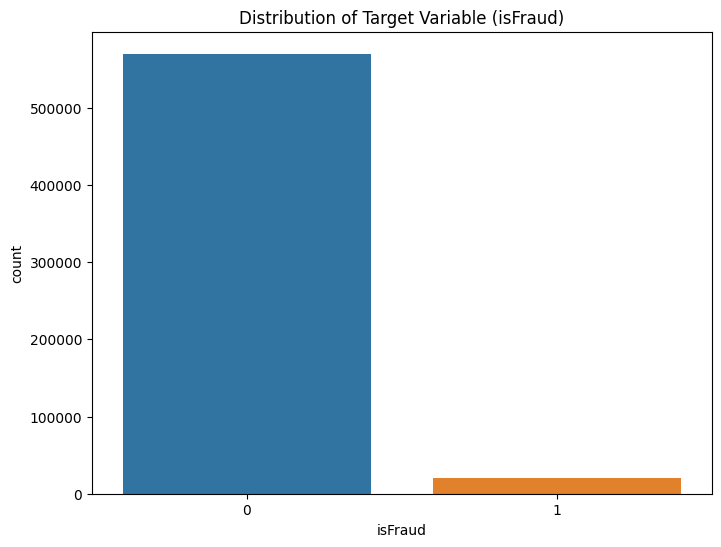


Step 4: Inspecting data...

Missing Values in Train Data:
TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
                   ...  
id_36             449555
id_37             449555
id_38             449555
DeviceType        449730
DeviceInfo        471874
Length: 434, dtype: int64

Missing Values in Test Data:
TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
                   ...  
id_36             369714
id_37             369714
id_38             369714
DeviceType        369760
DeviceInfo        391634
Length: 433, dtype: int64

Number of duplicate rows in Train Data: 0
Number of duplicate rows in Test Data: 0

Step 5: Cleaning data...
🏃 View run skillful-sloth-914 at: https://dagshub.com/mkoko22/mkoko22-ML-2.mlflow/#/experiments/0/runs/8bc27ccb347749f1849cdab6127bde28
🧪 View experiment at: https://dagshub.com/mkoko22/mkoko22-ML-2.

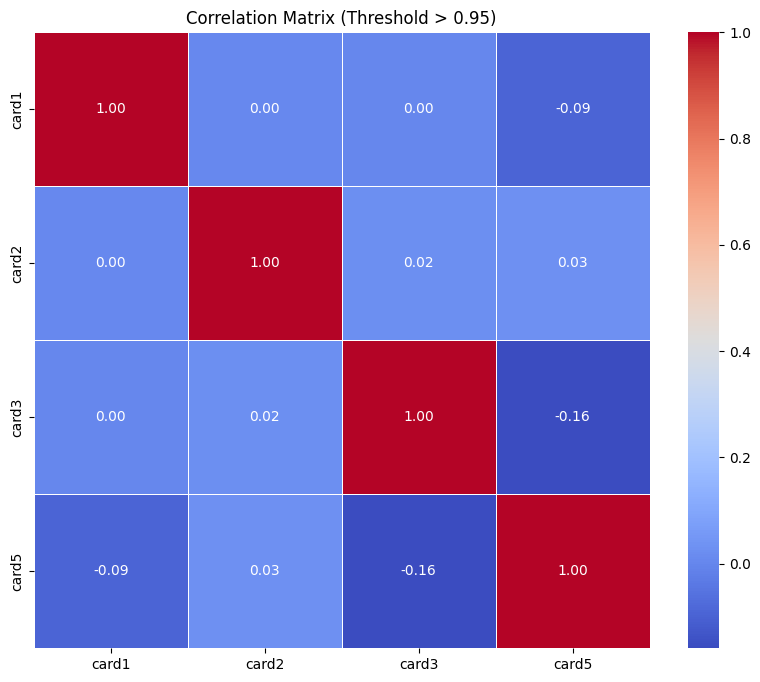

No high correlation pairs found in Card-related Features

Checking correlations for Address-related Features...

No pairs found with correlation greater than 0.95.


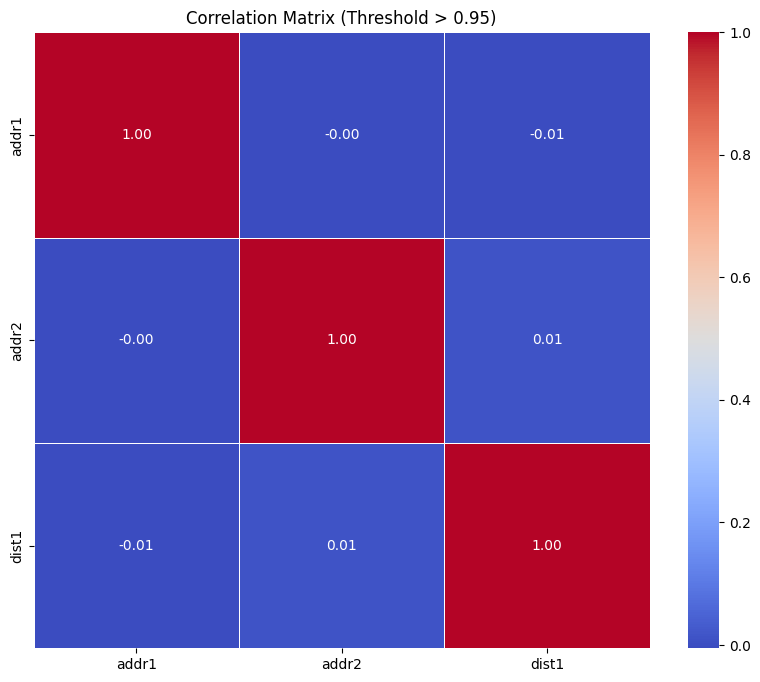

No high correlation pairs found in Address-related Features

Checking correlations for D Features...

No pairs found with correlation greater than 0.95.


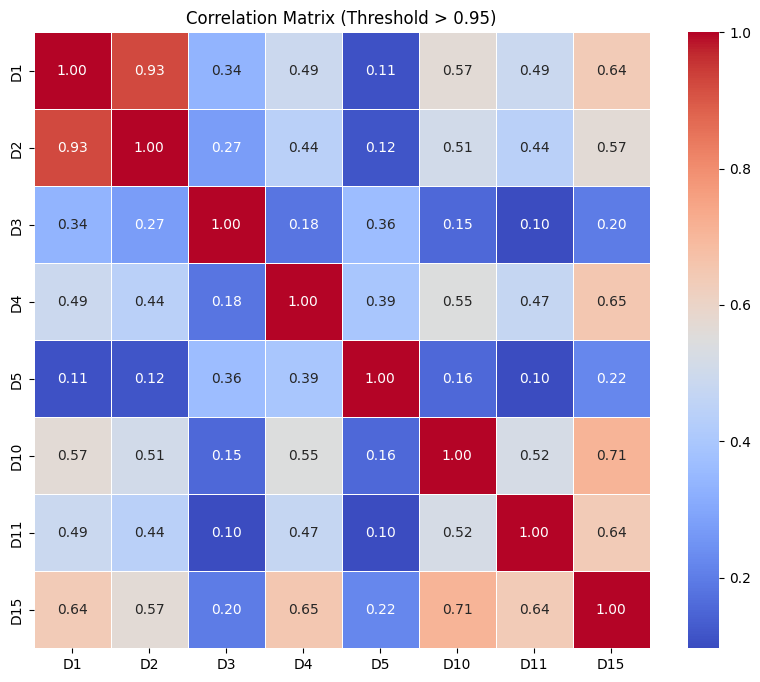

No high correlation pairs found in D Features

Checking correlations for ID Features...

No pairs found with correlation greater than 0.95.


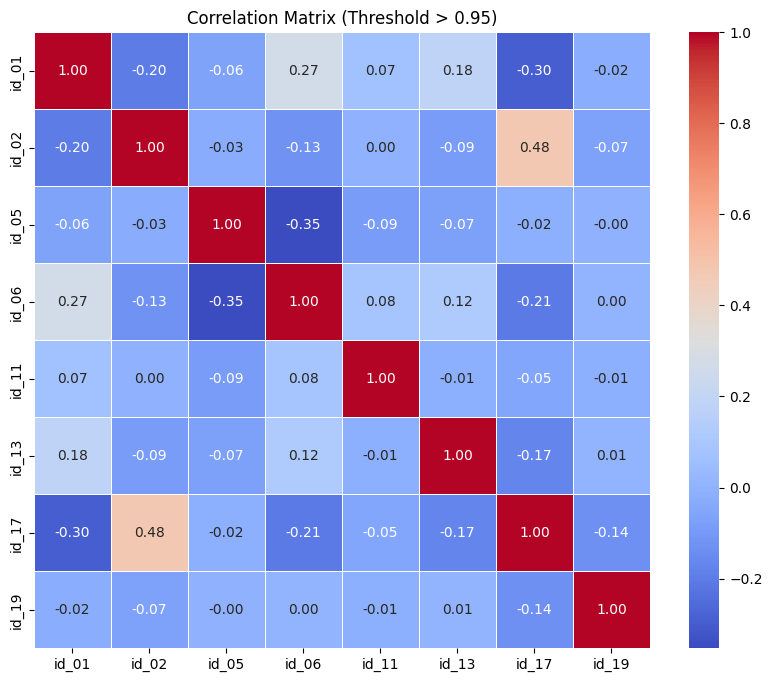

No high correlation pairs found in ID Features

Checking correlations for C Features...

High correlation pairs (correlation > 0.95):
C2 & C1: 1.00
C4 & C1: 0.97
C4 & C2: 0.97
C6 & C1: 0.98
C6 & C2: 0.97
C6 & C4: 0.96
C8 & C1: 0.97
C8 & C2: 0.98
C8 & C4: 0.96
C8 & C7: 0.98
C10 & C1: 0.96
C10 & C2: 0.97
C10 & C4: 0.95
C10 & C7: 0.99
C10 & C8: 1.00
C11 & C1: 1.00
C11 & C2: 0.99
C11 & C4: 0.97
C11 & C6: 0.99
C11 & C8: 0.96
C11 & C10: 0.96
C12 & C7: 1.00
C12 & C8: 0.98
C12 & C10: 0.98
C14 & C1: 0.95
C14 & C6: 0.98
C14 & C11: 0.96


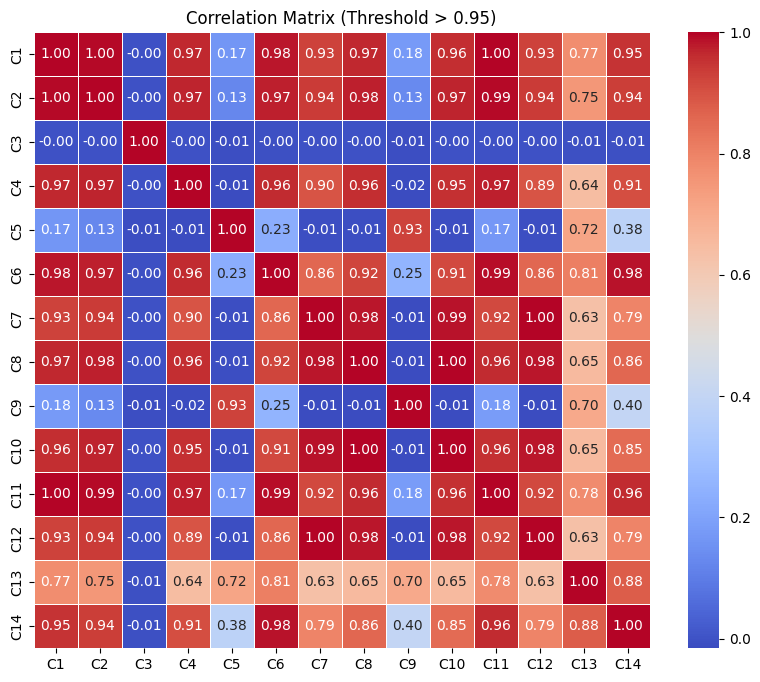

Found high correlation pairs in C Features:
[('C2', 'C1', 0.9950894592234939), ('C4', 'C1', 0.9678002004097163), ('C4', 'C2', 0.9721337740566047), ('C6', 'C1', 0.9822377722079176), ('C6', 'C2', 0.9748448481316238), ('C6', 'C4', 0.9623192744263843), ('C8', 'C1', 0.9677463528943373), ('C8', 'C2', 0.9758629919515445), ('C8', 'C4', 0.9599954810304452), ('C8', 'C7', 0.9829833764483118), ('C10', 'C1', 0.9582021807774743), ('C10', 'C2', 0.9706239088171714), ('C10', 'C4', 0.9524664323346516), ('C10', 'C7', 0.9850616676560336), ('C10', 'C8', 0.9969699489971502), ('C11', 'C1', 0.9965147332633475), ('C11', 'C2', 0.9938978018238349), ('C11', 'C4', 0.9745466372849689), ('C11', 'C6', 0.9911048342777391), ('C11', 'C8', 0.9627215780026751), ('C11', 'C10', 0.9560557324215362), ('C12', 'C7', 0.9994888253017926), ('C12', 'C8', 0.9830271643527599), ('C12', 'C10', 0.9838169468512061), ('C14', 'C1', 0.9517609999340592), ('C14', 'C6', 0.984201070361345), ('C14', 'C11', 0.9624645830405704)]

Step 5.2: Running

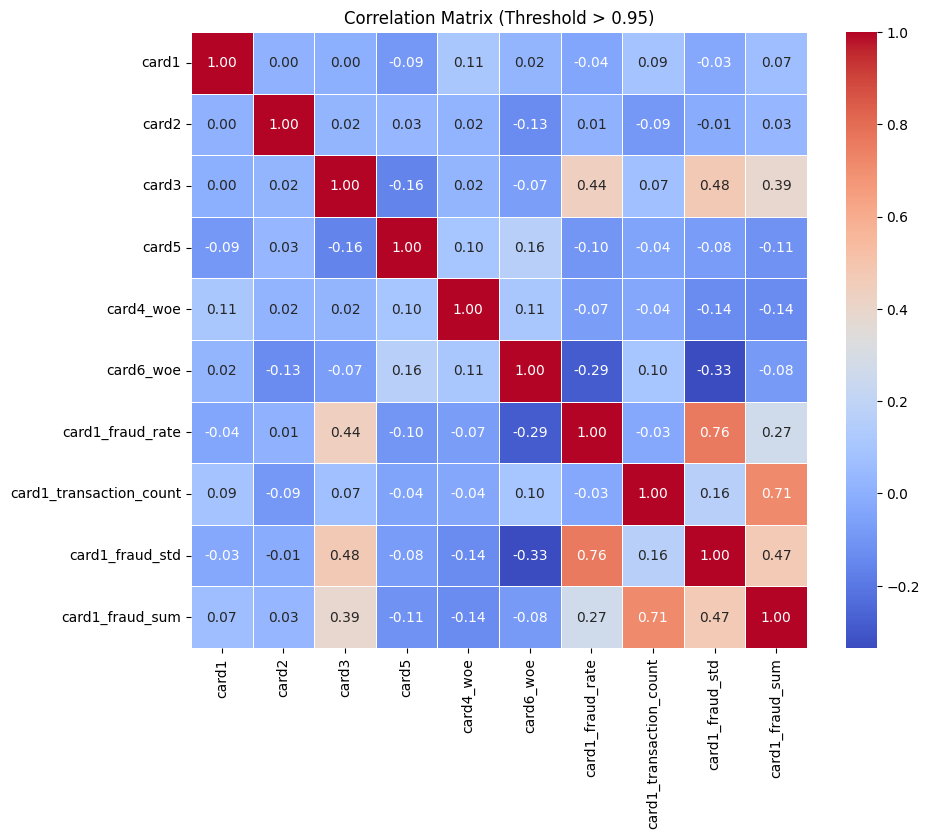

No high correlation pairs found in Card-related Features

Checking correlations for Address-related Features...

No pairs found with correlation greater than 0.95.


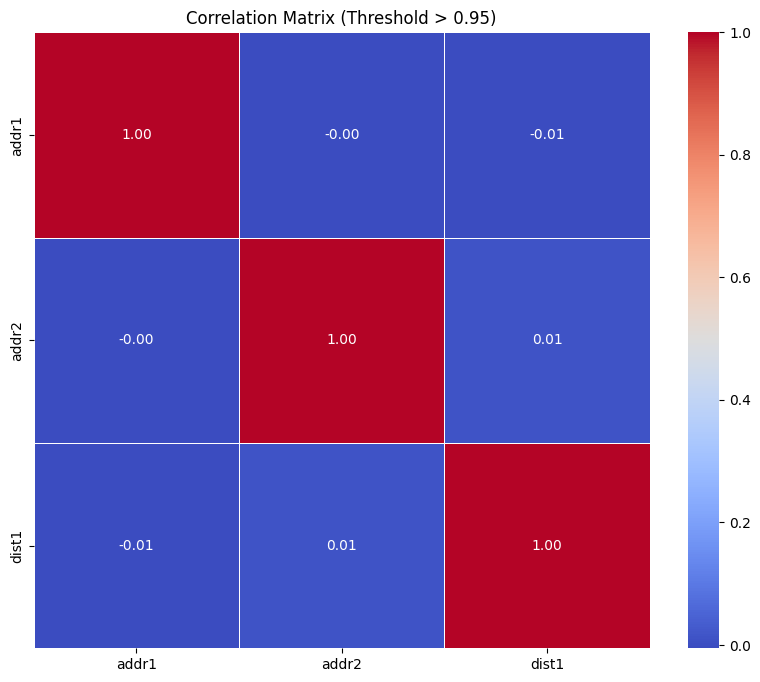

No high correlation pairs found in Address-related Features

Checking correlations for D Features...

No pairs found with correlation greater than 0.95.


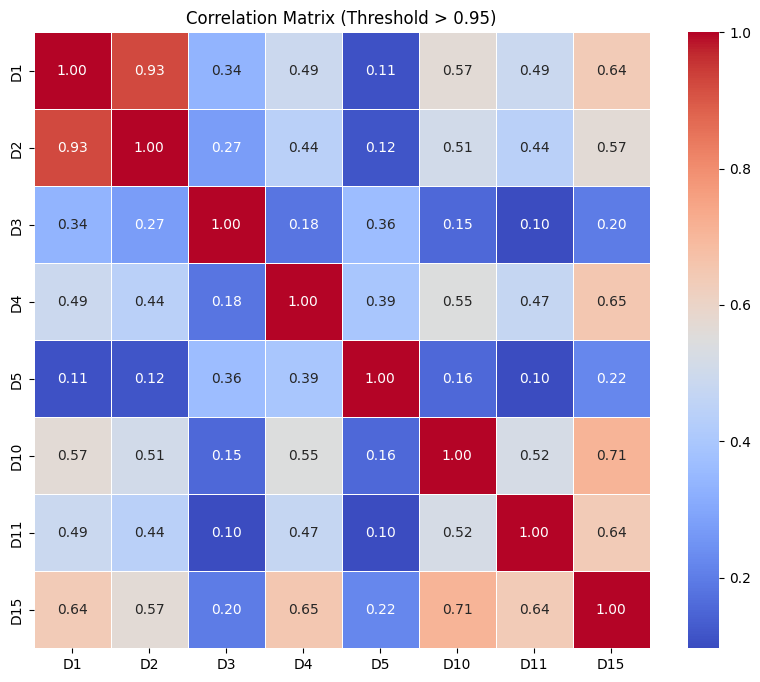

No high correlation pairs found in D Features

Checking correlations for ID Features...

No pairs found with correlation greater than 0.95.


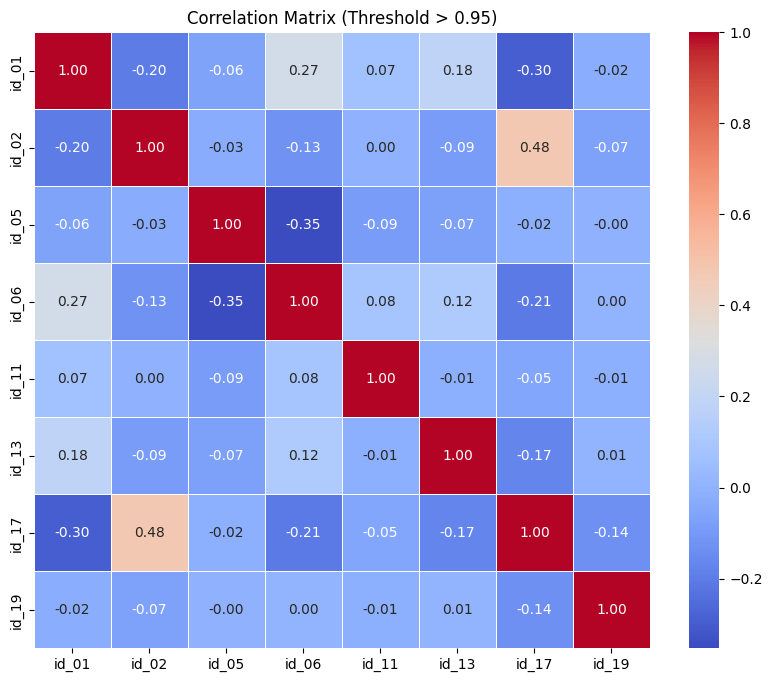

No high correlation pairs found in ID Features

Checking correlations for C Features...

High correlation pairs (correlation > 0.95):
C2 & C1: 1.00
C4 & C1: 0.97
C4 & C2: 0.97
C6 & C1: 0.98
C6 & C2: 0.97
C6 & C4: 0.96
C8 & C1: 0.97
C8 & C2: 0.98
C8 & C4: 0.96
C8 & C7: 0.98
C10 & C1: 0.96
C10 & C2: 0.97
C10 & C4: 0.95
C10 & C7: 0.99
C10 & C8: 1.00
C11 & C1: 1.00
C11 & C2: 0.99
C11 & C4: 0.97
C11 & C6: 0.99
C11 & C8: 0.96
C11 & C10: 0.96
C12 & C7: 1.00
C12 & C8: 0.98
C12 & C10: 0.98
C14 & C1: 0.95
C14 & C6: 0.98
C14 & C11: 0.96


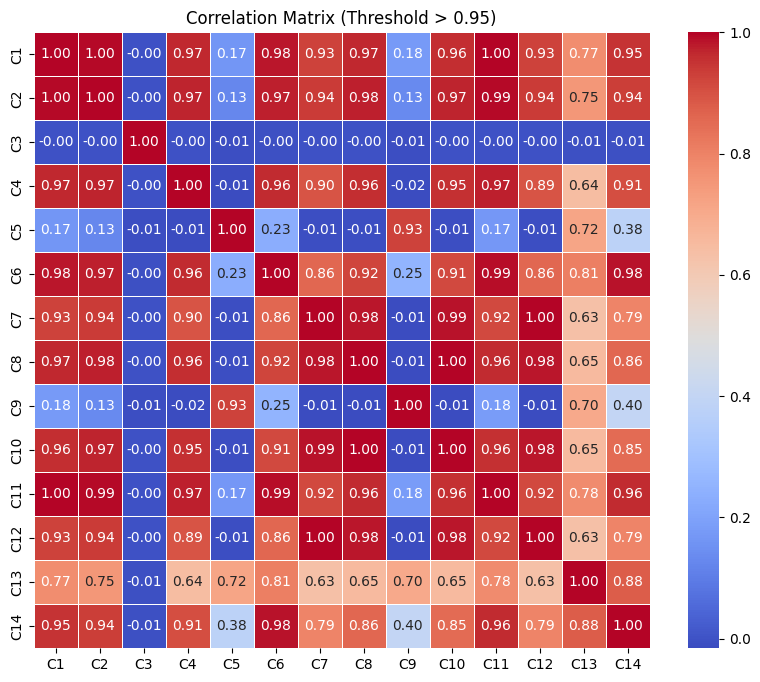

Found high correlation pairs in C Features:
[('C2', 'C1', 0.9950894592234939), ('C4', 'C1', 0.9678002004097163), ('C4', 'C2', 0.9721337740566047), ('C6', 'C1', 0.9822377722079176), ('C6', 'C2', 0.9748448481316238), ('C6', 'C4', 0.9623192744263843), ('C8', 'C1', 0.9677463528943373), ('C8', 'C2', 0.9758629919515445), ('C8', 'C4', 0.9599954810304452), ('C8', 'C7', 0.9829833764483118), ('C10', 'C1', 0.9582021807774743), ('C10', 'C2', 0.9706239088171714), ('C10', 'C4', 0.9524664323346516), ('C10', 'C7', 0.9850616676560336), ('C10', 'C8', 0.9969699489971502), ('C11', 'C1', 0.9965147332633475), ('C11', 'C2', 0.9938978018238349), ('C11', 'C4', 0.9745466372849689), ('C11', 'C6', 0.9911048342777391), ('C11', 'C8', 0.9627215780026751), ('C11', 'C10', 0.9560557324215362), ('C12', 'C7', 0.9994888253017926), ('C12', 'C8', 0.9830271643527599), ('C12', 'C10', 0.9838169468512061), ('C14', 'C1', 0.9517609999340592), ('C14', 'C6', 0.984201070361345), ('C14', 'C11', 0.9624645830405704)]

Checking batch 1/

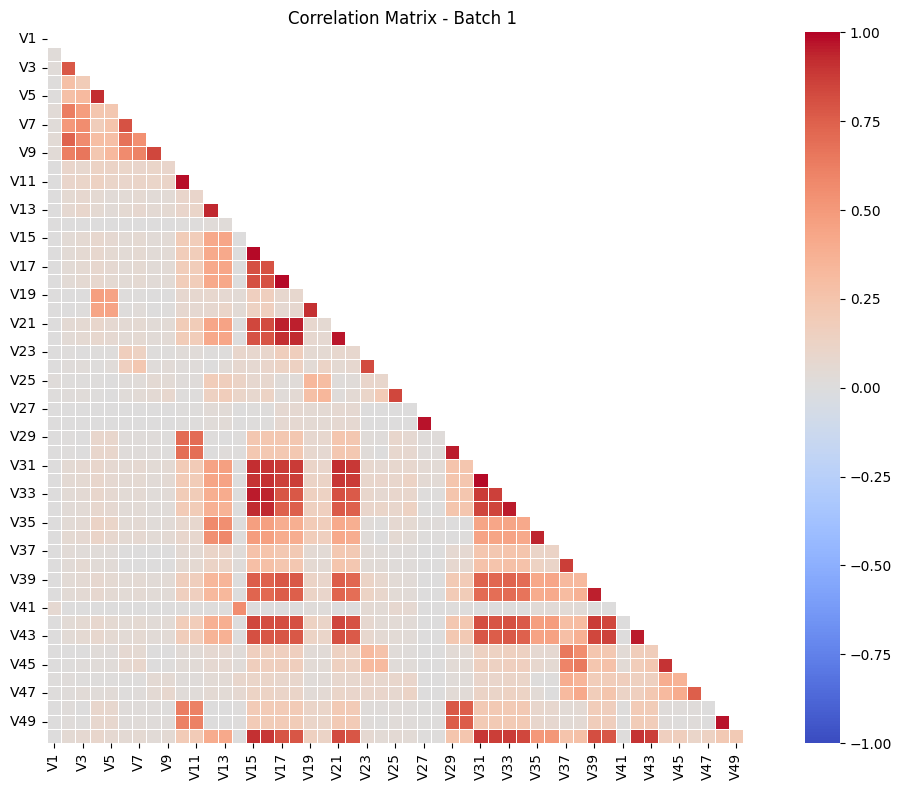

Keeping: V11
Dropping: ['V10']
Keeping: V15
Dropping: ['V33', 'V16', 'V34']
Keeping: V17
Dropping: ['V21', 'V18', 'V22']
Keeping: V28
Dropping: ['V27']
Keeping: V30
Dropping: ['V29']
Keeping: V32
Dropping: ['V31']
Keeping: V43
Dropping: ['V42']
Keeping: V49
Dropping: ['V48']

Processing batch 2/6: 50 columns
Found 10 high correlation pairs


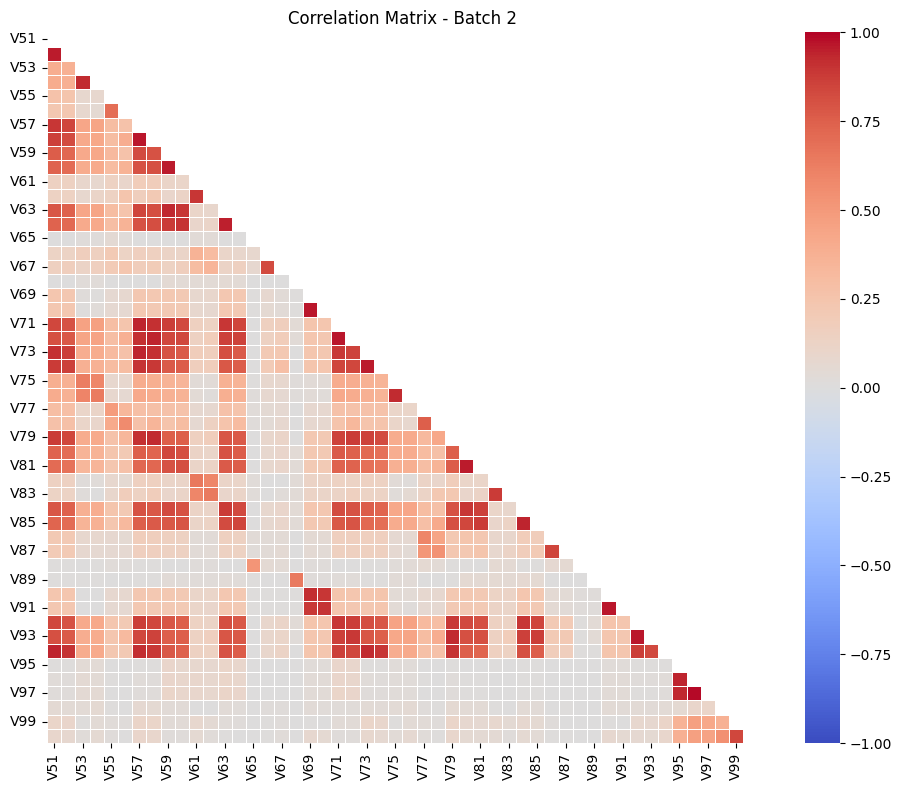

Keeping: V11
Dropping: ['V10']
Keeping: V16
Dropping: ['V15', 'V33', 'V34']
Keeping: V18
Dropping: ['V17', 'V21', 'V22']
Keeping: V28
Dropping: ['V27']
Keeping: V30
Dropping: ['V29']
Keeping: V32
Dropping: ['V31']
Keeping: V43
Dropping: ['V42']
Keeping: V49
Dropping: ['V48']
Keeping: V52
Dropping: ['V51']
Keeping: V58
Dropping: ['V57']
Keeping: V60
Dropping: ['V59']
Keeping: V70
Dropping: ['V69']
Keeping: V72
Dropping: ['V71']
Keeping: V74
Dropping: ['V73']
Keeping: V81
Dropping: ['V80']
Keeping: V91
Dropping: ['V90']
Keeping: V93
Dropping: ['V92']
Keeping: V97
Dropping: ['V96']

Processing batch 3/6: 50 columns
Found 49 high correlation pairs


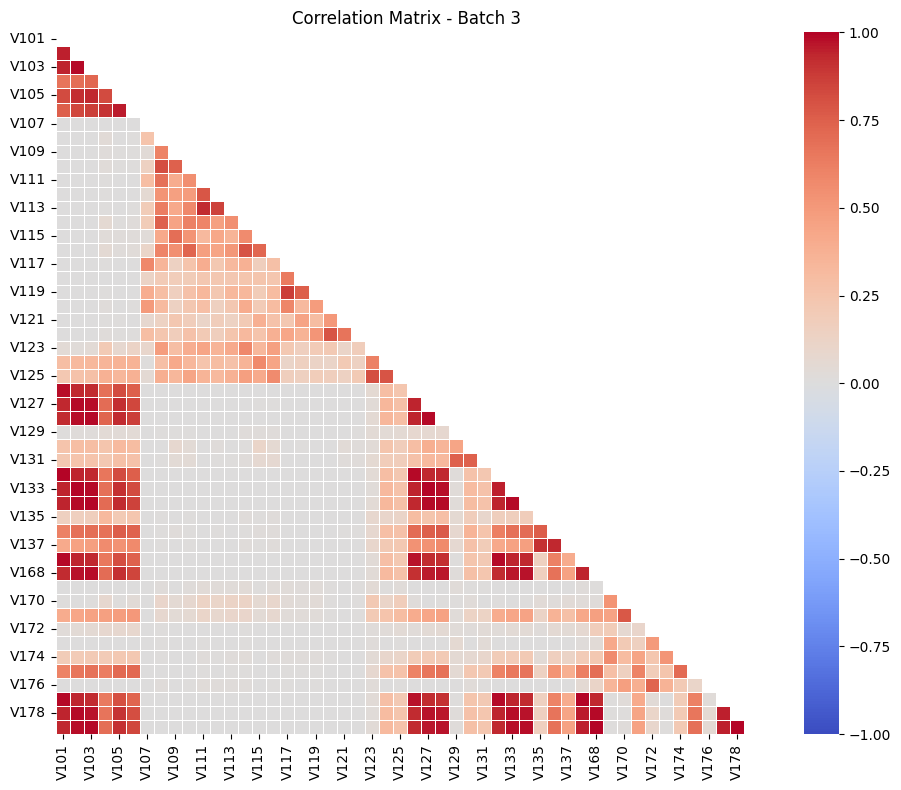

Keeping: V11
Dropping: ['V10']
Keeping: V16
Dropping: ['V15', 'V33', 'V34']
Keeping: V18
Dropping: ['V17', 'V21', 'V22']
Keeping: V28
Dropping: ['V27']
Keeping: V30
Dropping: ['V29']
Keeping: V32
Dropping: ['V31']
Keeping: V43
Dropping: ['V42']
Keeping: V49
Dropping: ['V48']
Keeping: V52
Dropping: ['V51']
Keeping: V58
Dropping: ['V57']
Keeping: V60
Dropping: ['V59']
Keeping: V70
Dropping: ['V69']
Keeping: V72
Dropping: ['V71']
Keeping: V74
Dropping: ['V73']
Keeping: V81
Dropping: ['V80']
Keeping: V91
Dropping: ['V90']
Keeping: V93
Dropping: ['V92']
Keeping: V97
Dropping: ['V96']
Keeping: V134
Dropping: ['V102', 'V103', 'V133', 'V179', 'V178', 'V127', 'V128', 'V168']
Keeping: V106
Dropping: ['V105']
Keeping: V132
Dropping: ['V101', 'V177', 'V167', 'V126']

Processing batch 4/6: 50 columns
Found 15 high correlation pairs


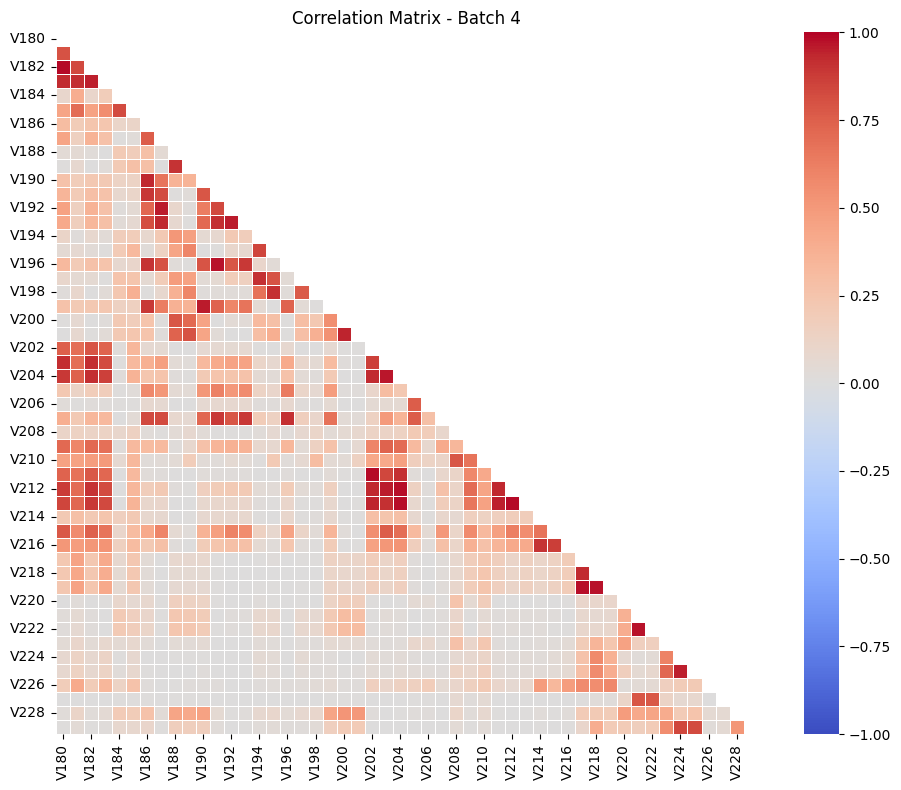

Keeping: V11
Dropping: ['V10']
Keeping: V16
Dropping: ['V15', 'V33', 'V34']
Keeping: V18
Dropping: ['V17', 'V21', 'V22']
Keeping: V28
Dropping: ['V27']
Keeping: V30
Dropping: ['V29']
Keeping: V32
Dropping: ['V31']
Keeping: V43
Dropping: ['V42']
Keeping: V49
Dropping: ['V48']
Keeping: V52
Dropping: ['V51']
Keeping: V58
Dropping: ['V57']
Keeping: V60
Dropping: ['V59']
Keeping: V70
Dropping: ['V69']
Keeping: V72
Dropping: ['V71']
Keeping: V74
Dropping: ['V73']
Keeping: V81
Dropping: ['V80']
Keeping: V91
Dropping: ['V90']
Keeping: V93
Dropping: ['V92']
Keeping: V97
Dropping: ['V96']
Keeping: V103
Dropping: ['V102', 'V127', 'V128', 'V133', 'V134', 'V168', 'V178', 'V179']
Keeping: V106
Dropping: ['V105']
Keeping: V126
Dropping: ['V101', 'V132', 'V167', 'V177']
Keeping: V182
Dropping: ['V180']
Keeping: V192
Dropping: ['V187', 'V193']
Keeping: V196
Dropping: ['V191']
Keeping: V199
Dropping: ['V190']
Keeping: V212
Dropping: ['V204', 'V213', 'V203']
Keeping: V211
Dropping: ['V202']
Keeping: V219

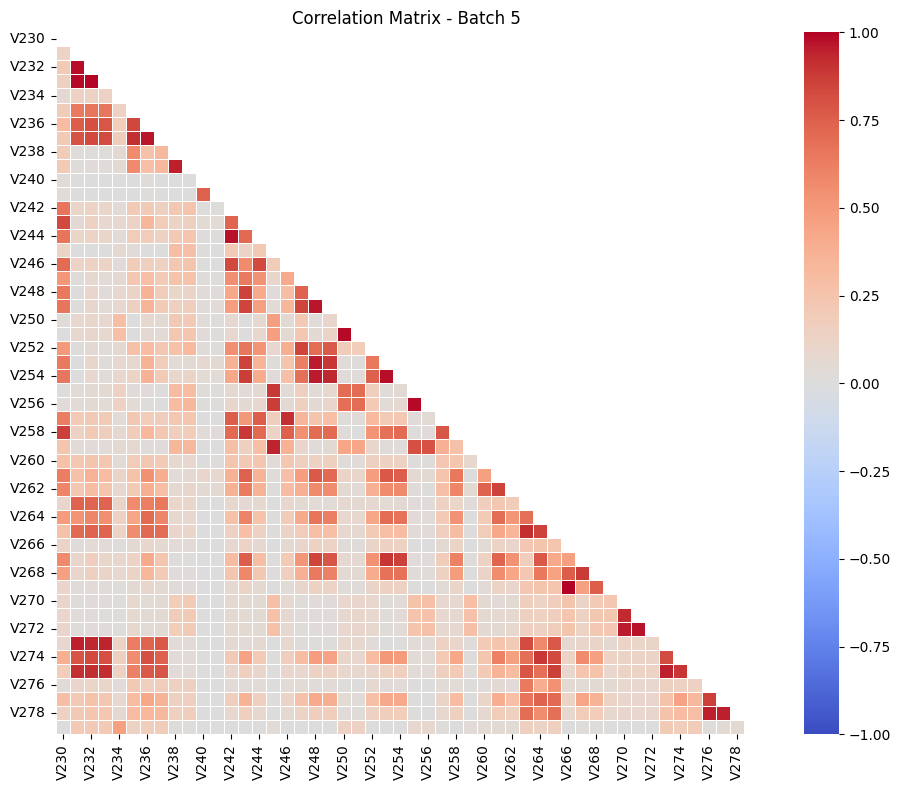

Keeping: V11
Dropping: ['V10']
Keeping: V16
Dropping: ['V15', 'V33', 'V34']
Keeping: V18
Dropping: ['V17', 'V21', 'V22']
Keeping: V28
Dropping: ['V27']
Keeping: V30
Dropping: ['V29']
Keeping: V32
Dropping: ['V31']
Keeping: V43
Dropping: ['V42']
Keeping: V49
Dropping: ['V48']
Keeping: V52
Dropping: ['V51']
Keeping: V58
Dropping: ['V57']
Keeping: V60
Dropping: ['V59']
Keeping: V70
Dropping: ['V69']
Keeping: V72
Dropping: ['V71']
Keeping: V74
Dropping: ['V73']
Keeping: V81
Dropping: ['V80']
Keeping: V91
Dropping: ['V90']
Keeping: V93
Dropping: ['V92']
Keeping: V97
Dropping: ['V96']
Keeping: V103
Dropping: ['V102', 'V127', 'V128', 'V133', 'V134', 'V168', 'V178', 'V179']
Keeping: V106
Dropping: ['V105']
Keeping: V126
Dropping: ['V101', 'V132', 'V167', 'V177']
Keeping: V182
Dropping: ['V180']
Keeping: V192
Dropping: ['V187', 'V193']
Keeping: V196
Dropping: ['V191']
Keeping: V199
Dropping: ['V190']
Keeping: V204
Dropping: ['V203', 'V212', 'V213']
Keeping: V211
Dropping: ['V202']
Keeping: V219

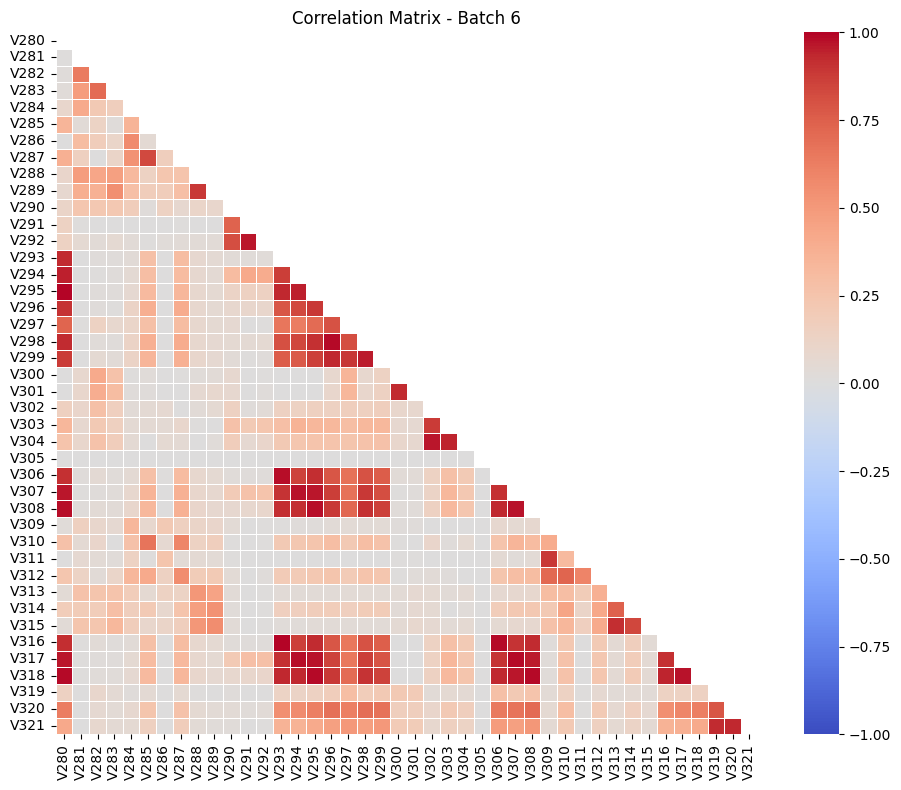

Keeping: V11
Dropping: ['V10']
Keeping: V16
Dropping: ['V15', 'V33', 'V34']
Keeping: V18
Dropping: ['V17', 'V21', 'V22']
Keeping: V28
Dropping: ['V27']
Keeping: V30
Dropping: ['V29']
Keeping: V32
Dropping: ['V31']
Keeping: V43
Dropping: ['V42']
Keeping: V49
Dropping: ['V48']
Keeping: V52
Dropping: ['V51']
Keeping: V58
Dropping: ['V57']
Keeping: V60
Dropping: ['V59']
Keeping: V70
Dropping: ['V69']
Keeping: V72
Dropping: ['V71']
Keeping: V74
Dropping: ['V73']
Keeping: V81
Dropping: ['V80']
Keeping: V91
Dropping: ['V90']
Keeping: V93
Dropping: ['V92']
Keeping: V97
Dropping: ['V96']
Keeping: V103
Dropping: ['V102', 'V127', 'V128', 'V133', 'V134', 'V168', 'V178', 'V179']
Keeping: V106
Dropping: ['V105']
Keeping: V126
Dropping: ['V101', 'V132', 'V167', 'V177']
Keeping: V182
Dropping: ['V180']
Keeping: V192
Dropping: ['V187', 'V193']
Keeping: V196
Dropping: ['V191']
Keeping: V199
Dropping: ['V190']
Keeping: V204
Dropping: ['V203', 'V212', 'V213']
Keeping: V211
Dropping: ['V202']
Keeping: V219

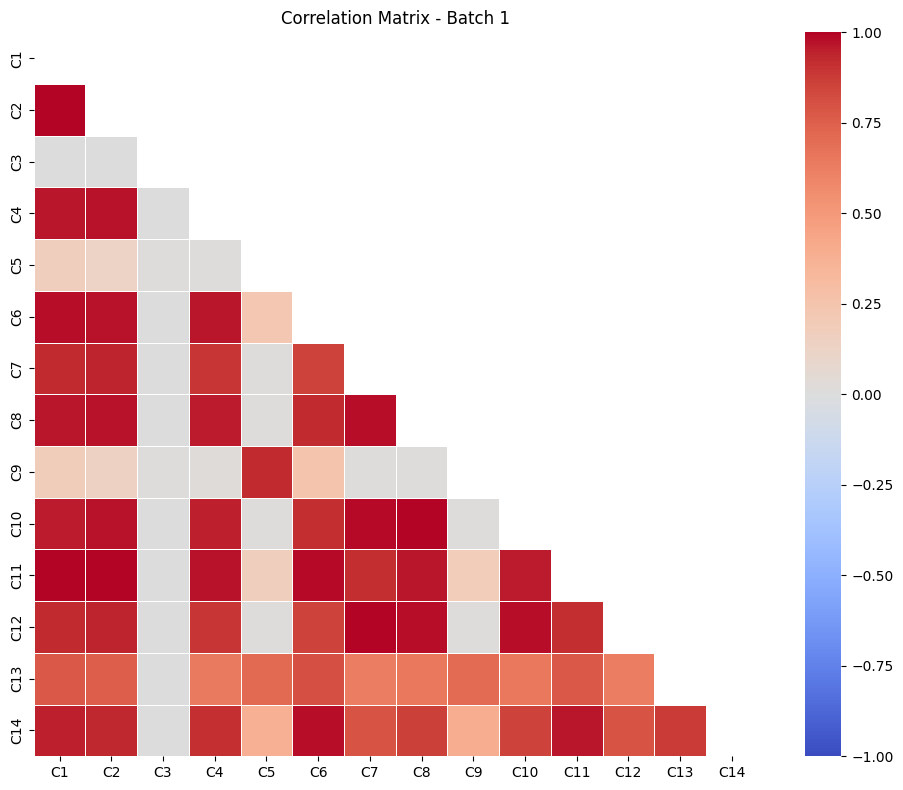

Keeping: C11
Dropping: ['C8', 'C1', 'C10', 'C2', 'C4', 'C6', 'C7', 'C12', 'C14']

Dropping 9 columns in total
Final train shape: (590540, 275)
Final test shape: (506691, 274)
Dropped columns: ['C8', 'C1', 'C10', 'C2', 'C4', 'C6', 'C7', 'C12', 'C14']
Correlation groups (with drops): [['C2', 'C1', 'C4', 'C6', 'C8', 'C7', 'C10', 'C11', 'C12', 'C14']]
Correlation groups (without drops): []
Outliers capped successfully
Outliers capped successfully
Preparing data for modeling...
Done.
Training features shape: (590540, 273)
Testing features shape: (506691,)

Step 11: Selecting important features...

Selecting top 100 features using Random Forest importance...
Detected infinite values. Replacing with NaN...
Detected missing values. Imputing before feature selection...
Selected 100 features:
['card1_fraud_rate', 'card1_fraud_std', 'TransactionDT', 'TransactionAmt', 'C11', 'card1_fraud_sum', 'card1_transaction_count', 'C13', 'card1', 'DeviceInfo_woe', 'addr1', 'card2', 'P_emaildomain_woe', 'id_0

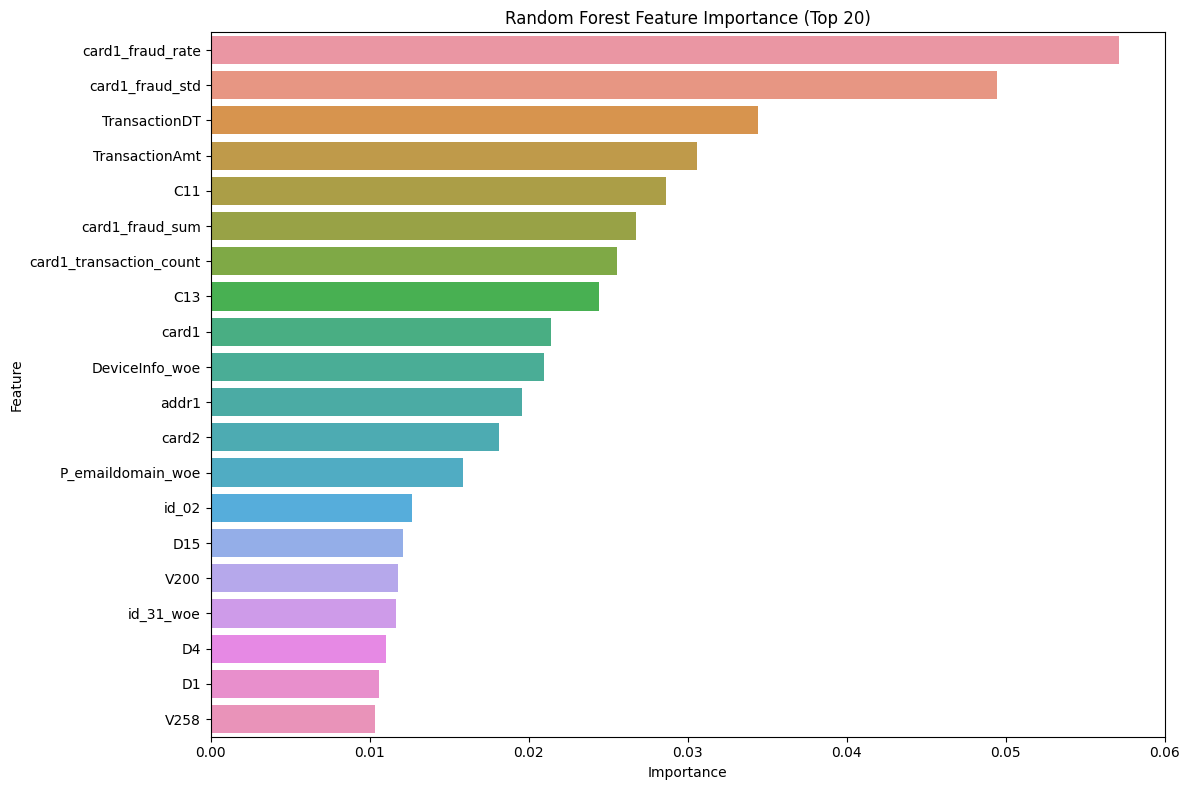

🏃 View run feature_selection at: https://dagshub.com/mkoko22/mkoko22-ML-2.mlflow/#/experiments/0/runs/c7cd4c1668ec4571b71da91eb6026963
🧪 View experiment at: https://dagshub.com/mkoko22/mkoko22-ML-2.mlflow/#/experiments/0

Step 12: Training model with cross-validation...

Training XGBoost model with cross-validation...
Balancing the dataset using Random Under Sampling...
Original class distribution: isFraud
0.0    569877
1.0     20663
Name: count, dtype: int64
Resampled class distribution: isFraud
0.0    103315
1.0     20663
Name: count, dtype: int64
Tuning XGBoost hyperparameters...
Training data is large, using 20000 samples for hyperparameter tuning
Starting hyperparameter search...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters found: {'subsample': 0.6, 'scale_pos_weight': 3, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.9}
Best F1 score: 0.7641

Fold 1/5
Balancing the dataset usin

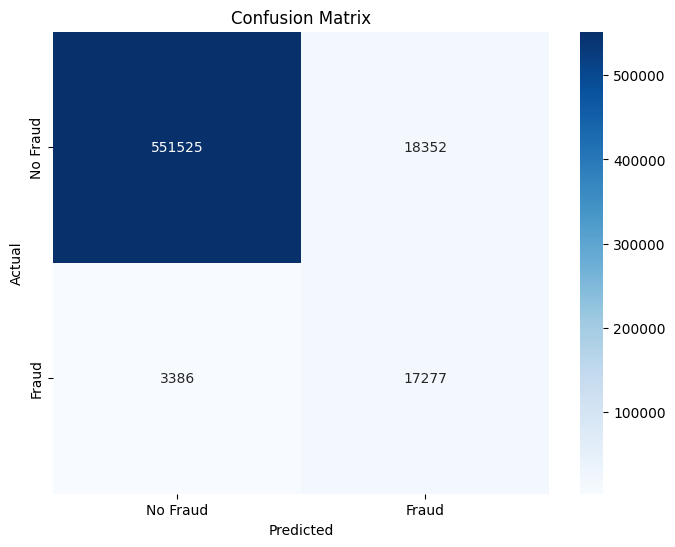

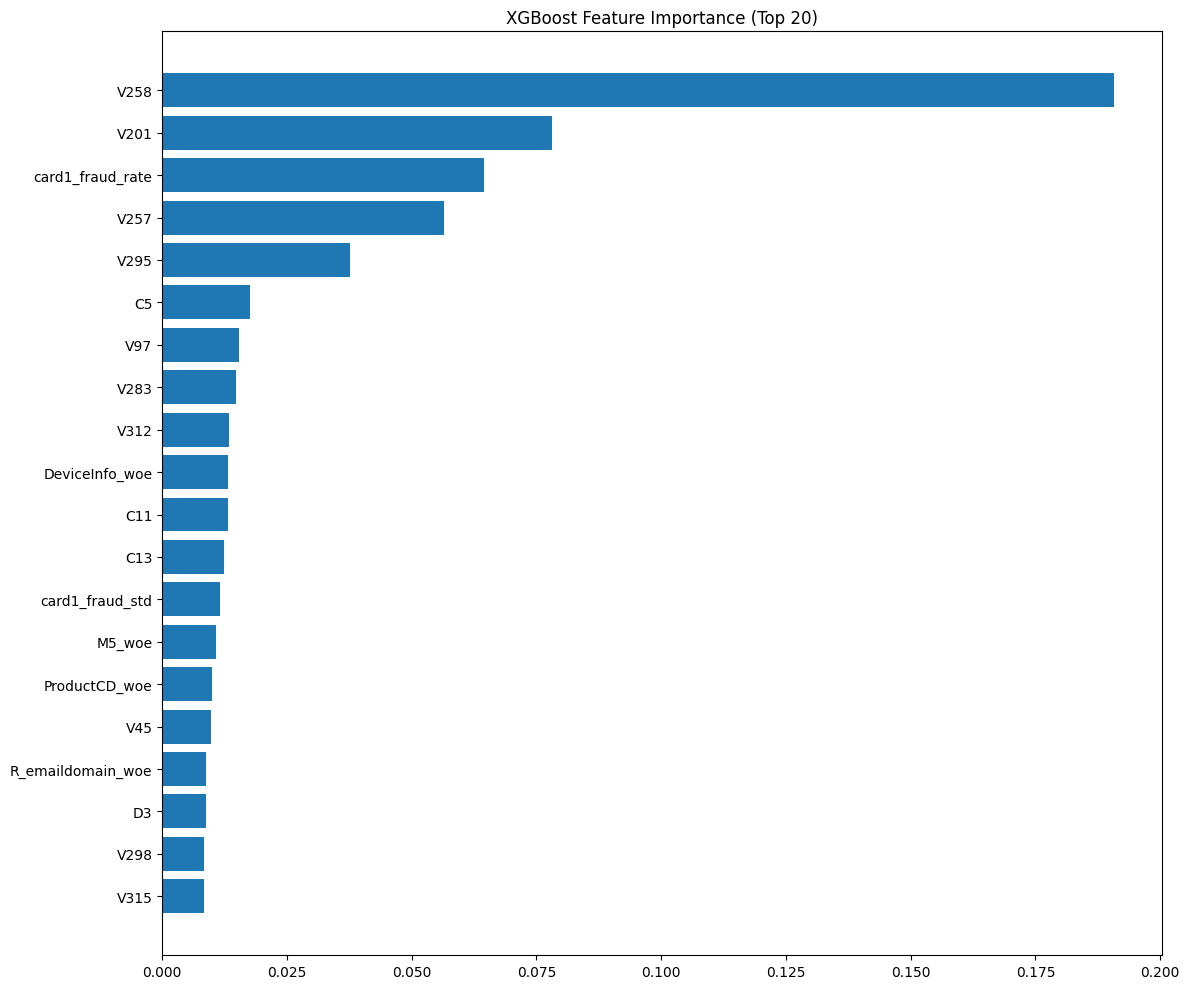

🏃 View run model_training at: https://dagshub.com/mkoko22/mkoko22-ML-2.mlflow/#/experiments/0/runs/2bfd0ac622fb4c76a71a7e9bb40c7223
🧪 View experiment at: https://dagshub.com/mkoko22/mkoko22-ML-2.mlflow/#/experiments/0

Fraud detection pipeline completed successfully!


In [34]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


def train_xgboost_with_cv(X, y, selected_features, n_folds=5):
    print("\nTraining XGBoost model with cross-validation...")
    
    X_selected = X[selected_features]
    
    X_train_balanced, y_train_balanced = balance_data(X_selected, y)
    model, best_params, best_f1 = tune_xgboost_hyperparameters(X_train_balanced, y_train_balanced)

    kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    cv_scores = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    fold_predictions = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_selected, y)):
        print(f"\nFold {fold+1}/{n_folds}")
        
        X_train_fold, X_val_fold = X_selected.iloc[train_idx], X_selected.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        
        X_train_balanced, y_train_balanced = balance_data(X_train_fold, y_train_fold)
       
        model.fit(
            X_train_balanced, 
            y_train_balanced, 
            eval_set=[(X_val_fold, y_val_fold)],
            verbose=100,
            early_stopping_rounds=50
        )
       
        val_preds = model.predict_proba(X_val_fold)[:, 1]
       
        threshold = 0.6
       
        y_pred = (val_preds >= threshold).astype(int)

        auc_score = roc_auc_score(y_val_fold, val_preds)
        accuracy = accuracy_score(y_val_fold, y_pred)
        precision = precision_score(y_val_fold, y_pred)
        recall = recall_score(y_val_fold, y_pred)
        f1 = f1_score(y_val_fold, y_pred)
        
        cv_scores.append(auc_score)
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        
        print(f"Fold {fold+1} AUC: {auc_score:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
       
        fold_predictions.append(pd.Series(val_preds, index=val_idx))
   
    oof_predictions = pd.concat(fold_predictions).sort_index()
   
    overall_auc = roc_auc_score(y, oof_predictions)
    mean_auc = np.mean(cv_scores)
    mean_accuracy = np.mean(accuracy_scores)
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_f1 = np.mean(f1_scores)
    
    print(f"\nOverall AUC score: {overall_auc:.4f}")
    print(f"Cross-validation AUC scores: {[round(score, 4) for score in cv_scores]}")
    print(f"Mean CV AUC score: {mean_auc:.4f}")
    print(f"Mean Accuracy score: {mean_accuracy:.4f}")
    print(f"Mean Precision score: {mean_precision:.4f}")
    print(f"Mean Recall score: {mean_recall:.4f}")
    print(f"Mean F1 score: {mean_f1:.4f}")
    
    y_pred_binary = (oof_predictions >= 0.5).astype(int)
    cm = confusion_matrix(y, y_pred_binary)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
   
    plt.figure(figsize=(12, 10))
    sorted_idx = np.argsort(model.feature_importances_)[-20:]
    plt.barh(range(len(sorted_idx)), model.feature_importances_[sorted_idx])
    plt.yticks(range(len(sorted_idx)), X_selected.columns[sorted_idx])
    plt.title('XGBoost Feature Importance (Top 20)')
    plt.tight_layout()
    plt.savefig("/kaggle/working/feature_importance.png")
    plt.show()
    
    return model, overall_auc, oof_predictions, cv_scores, accuracy_scores, precision_scores, recall_scores, f1_scores

def main():
    setup_mlflow()
   
    print("Step 1: Loading data...")
    train, test, ids = load_data()
    
    print("\nStep 2: Optimizing memory usage...")
    train = reduce_mem_usage(train)
    test = reduce_mem_usage(test)
    
    print("\nStep 3: Analyzing target distribution...")
    display_target_distribution(train)
   
    print("\nStep 4: Inspecting data...")
    train, test = inspect_data(train, test)
    
    print("\nStep 5: Cleaning data...")
    train, test = clean_data(train, test, 'isFraud', missing_threshold=0.8)

    analyze_v_columns(train, step=20)

    available_columns = train.columns.tolist()
    chunks = {
        'Card-related Features': [col for col in ['card1', 'card2', 'card3', 'card5'] if col in available_columns],
        'Address-related Features': [col for col in ['addr1', 'addr2', 'dist1'] if col in available_columns],
        'D Features': [col for col in ['D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15'] if col in available_columns],
        'ID Features': [col for col in ['id_01', 'id_02', 'id_05', 'id_06', 'id_11', 'id_13', 'id_17', 'id_19'] if col in available_columns],
        'C Features': [col for col in ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14'] if col in available_columns]
    }
    
    for chunk_name, chunk_columns in list(chunks.items()):
        if len(chunk_columns) < 2:
            print(f"Skipping {chunk_name} - not enough columns available")
            del chunks[chunk_name]
    
    if chunks:
        run_correlation_check_for_chunks(train, chunks, threshold=0.95)
    
    print("\nStep 5.2: Running batch correlation check for V features...")
    if any(col.startswith('V') for col in available_columns):
        v_correlations = batch_correlation_check(train, feature_prefix='V', threshold=0.9, batch_size=50)
    else:
        print("No V features found in the dataframe at this point")
    
    train, test = create_aggregate_features(train, test)
   
    print("\nStep 7: Encoding categorical variables...")
    train, test = woe_encoding(train, test, 'isFraud')
    train, test = missing_values(train, test)
    
    chunks = {
            'Card-related Features': [
                'card1', 'card2', 'card3', 'card5', 'card4_woe', 'card6_woe', 
                'card1_fraud_rate', 'card1_transaction_count', 'card1_fraud_std', 'card1_fraud_sum'
            ],
            'Address-related Features': [
                'addr1', 'addr2', 'dist1'
            ],
            'D Features': [
                'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15'
            ],
            'ID Features': [
                'id_01', 'id_02', 'id_05', 'id_06', 'id_11', 'id_13', 'id_17', 'id_19'
            ],
            'C Features': [
                'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14'
            ]
        }
    
    print("\nAnalyzing correlations in feature chunks...")
    run_correlation_check_for_chunks(train, chunks, threshold=0.95)
    
    high_corr_pairs = batch_correlation_check(train, feature_prefix='V', threshold=0.9, batch_size=50)
   
    train, test, dropped_columns, correlation_groups = analyze_and_drop_correlated_features(
        train=train,
        test=test,
        prefixes=['V'],
        threshold=0.95,
        batch_size=50,
        plot=True,
        verbose=True
    )

    train, test, dropped_columns, correlation_groups = analyze_and_drop_correlated_features(
        train=train,
        test=test,
        prefixes=['C'],
        threshold=0.95,
        batch_size=50,
        plot=True,
        verbose=True
    )
    
    correlation_groups_only = get_feature_correlation_groups(
        df=train,
        prefixes=['V'],
        threshold=0.95,
        batch_size=50
    )

    print("Dropped columns:", dropped_columns)
    print("Correlation groups (with drops):", correlation_groups)
    print("Correlation groups (without drops):", correlation_groups_only)
    
    train = cap_outliers(train, percentile=98)
    test = cap_outliers(test, percentile=98)
    
    mlflow.log_param("features_after_engineering", train.shape[1])

    X, y, test_ids, X_test = prepare_data(train, test)
    
    print(f"Training features shape: {X.shape}")
    print(f"Testing features shape: {X_test.shape}")
    
    print("\nStep 11: Selecting important features...")
    with mlflow.start_run(run_name="feature_selection", nested=True):
        selected_features = feature_selection_with_importance(X, y, n_features_to_select=100)
        mlflow.log_param("selected_feature_count", len(selected_features))
   
    print("\nStep 12: Training model with cross-validation...")
    with mlflow.start_run(run_name="model_training", nested=True):
        model, overall_auc, oof_predictions, cv_scores, accuracy_scores, precision_scores, recall_scores, f1_scores = train_xgboost_with_cv(
            X, y, selected_features, n_folds=5
        )
       
        mlflow.log_metric("overall_auc", overall_auc)
        mlflow.log_metric("mean_cv_auc", np.mean(cv_scores))
        mlflow.log_metric("mean_accuracy", np.mean(accuracy_scores))
        mlflow.log_metric("mean_precision", np.mean(precision_scores))
        mlflow.log_metric("mean_recall", np.mean(recall_scores))
        mlflow.log_metric("mean_f1", np.mean(f1_scores))
    
    print("\nFraud detection pipeline completed successfully!")

if __name__ == "__main__":
    main()

In [42]:
def load_data():
    print("Loading data files...")
    train = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
    test = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')
    
    original_test_ids = test['TransactionID'].copy()
    
    print(f"Train shape: {train.shape}")
    print(f"Test shape: {test.shape}")
    print(f"Original test IDs count: {len(original_test_ids)}")
    
    try:
        train_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
        test_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')
        
        print(f"Train identity shape: {train_identity.shape}")
        print(f"Test identity shape: {test_identity.shape}")
        
        train = train.merge(train_identity, on='TransactionID', how='left')
        test = test.merge(test_identity, on='TransactionID', how='left')
        
        print(f"Train shape after merge: {train.shape}")
        print(f"Test shape after merge: {test.shape}")
    except Exception as e:
        print(f"Note: Identity data not loaded. {str(e)}")
    
    print(f"Final train shape: {train.shape}, columns: {len(train.columns)}")
    print(f"Final test shape: {test.shape}, columns: {len(test.columns)}")
    
    if len(original_test_ids) != len(test):
        print("Test data row count changed during loading!")
    
    return train, test, original_test_ids

In [40]:
def prepare_data(train_df, test_df):
    print(f"Preparing data for modeling...")
    print(f"Train data shape: {train_df.shape}")
    print(f"Test data shape: {test_df.shape}")
    
    test_df_copy = test_df.copy()
    
    if 'TransactionID' in test_df_copy.columns:
        test_ids = test_df_copy['TransactionID'].copy()
    else:
        print("No TransactionID column found in test data")
        test_ids = pd.Series(range(len(test_df_copy)))
    
    print(f"Number of test IDs extracted: {len(test_ids)}")
    
    if 'isFraud' not in train_df.columns:
        raise ValueError("Target variable 'isFraud' not found in training data")
    
    y = train_df['isFraud']
    
    train_cols_to_drop = ['isFraud']
    if 'TransactionID' in train_df.columns:
        train_cols_to_drop.append('TransactionID')
    
    X = train_df.drop(columns=train_cols_to_drop, errors='ignore')
    
    test_cols_to_drop = []
    if 'TransactionID' in test_df_copy.columns:
        test_cols_to_drop.append('TransactionID')
    
    X_test = test_df_copy.drop(columns=test_cols_to_drop, errors='ignore')
    
    if 'isFraud' in X_test.columns:
        X_test = X_test.drop(columns=['isFraud'])
    
    common_cols = list(set(X.columns).intersection(set(X_test.columns)))
    print(f"Number of common columns between train and test: {len(common_cols)}")
    
    if len(common_cols) < len(X.columns):
        print(f"{len(X.columns) - len(common_cols)} columns in train are not in test")
    
    if len(common_cols) < len(X_test.columns):
        print(f"{len(X_test.columns) - len(common_cols)} columns in test are not in train")
    
    X = X[common_cols]
    X_test = X_test[common_cols]
    
    print(f"Final shapes - X: {X.shape}, y: {y.shape}, X_test: {X_test.shape}")
    
    return X, y, test_ids, X_test

Initialized MLflow to track repo "mkoko22/mkoko22-ML-2"

Repository mkoko22/mkoko22-ML-2 initialized!

MLflow tracking initialized successfully
Step 1: Loading data...
Loading data files...
Train shape: (590540, 394)
Test shape: (506691, 393)
Original test IDs count: 506691
Train identity shape: (144233, 41)
Test identity shape: (141907, 41)
Train shape after merge: (590540, 434)
Test shape after merge: (506691, 433)
Final train shape: (590540, 434), columns: 434
Final test shape: (506691, 433), columns: 433

Step 2: Optimizing memory usage...
Memory usage before optimization: 1955.37 MB
Memory usage after optimization: 1044.70 MB
Decreased by 46.6%
Memory usage before optimization: 1673.87 MB
Memory usage after optimization: 895.89 MB
Decreased by 46.5%

Step 3: Analyzing target distribution...

Target distribution:
Non-fraud: 96.50%
Fraud: 3.50%


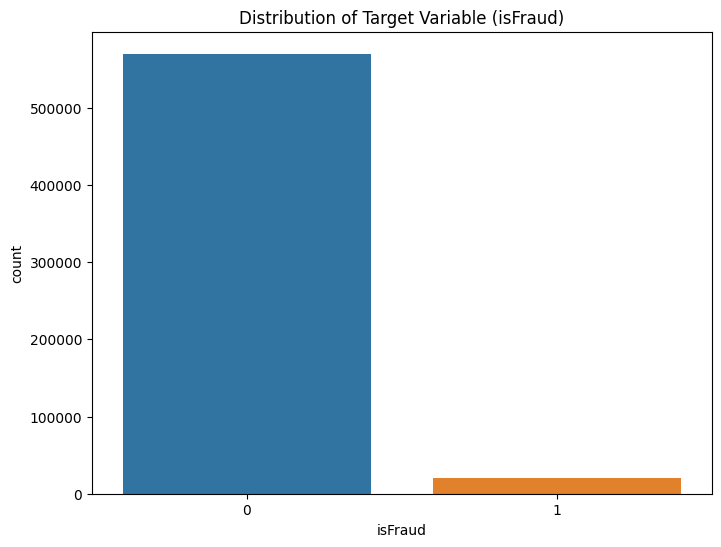


Step 4: Inspecting data...

Missing Values in Train Data:
TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
                   ...  
id_36             449555
id_37             449555
id_38             449555
DeviceType        449730
DeviceInfo        471874
Length: 434, dtype: int64

Missing Values in Test Data:
TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
                   ...  
id-36             369714
id-37             369714
id-38             369714
DeviceType        369760
DeviceInfo        391634
Length: 433, dtype: int64

Number of duplicate rows in Train Data: 0
Number of duplicate rows in Test Data: 0

Step 5: Cleaning data...
🏃 View run zealous-toad-50 at: https://dagshub.com/mkoko22/mkoko22-ML-2.mlflow/#/experiments/0/runs/776c5d8e29cd4ceeb72f27811c03e896
🧪 View experiment at: https://dagshub.com/mkoko22/mkoko22-ML-2.mlf

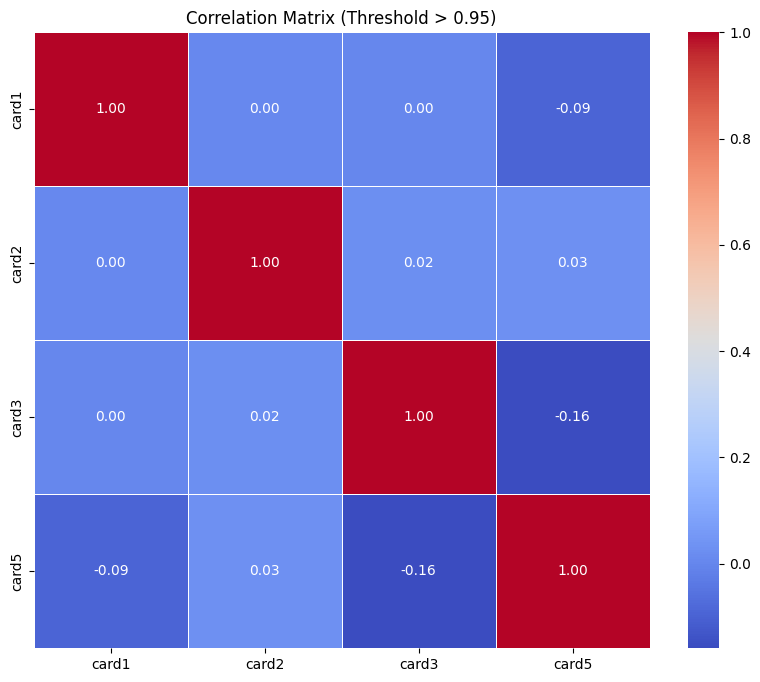

No high correlation pairs found in Card-related Features

Checking correlations for Address-related Features...

No pairs found with correlation greater than 0.95.


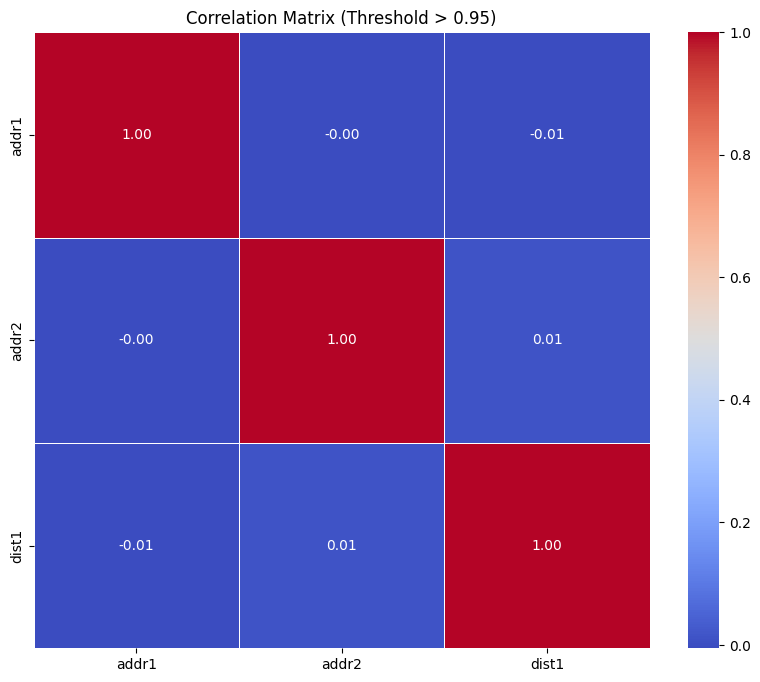

No high correlation pairs found in Address-related Features

Checking correlations for D Features...

No pairs found with correlation greater than 0.95.


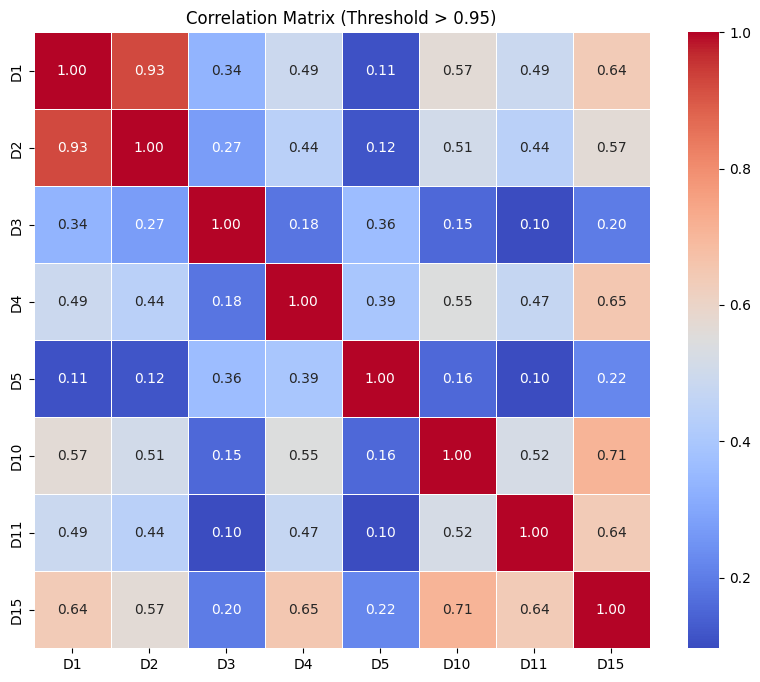

No high correlation pairs found in D Features

Checking correlations for ID Features...

No pairs found with correlation greater than 0.95.


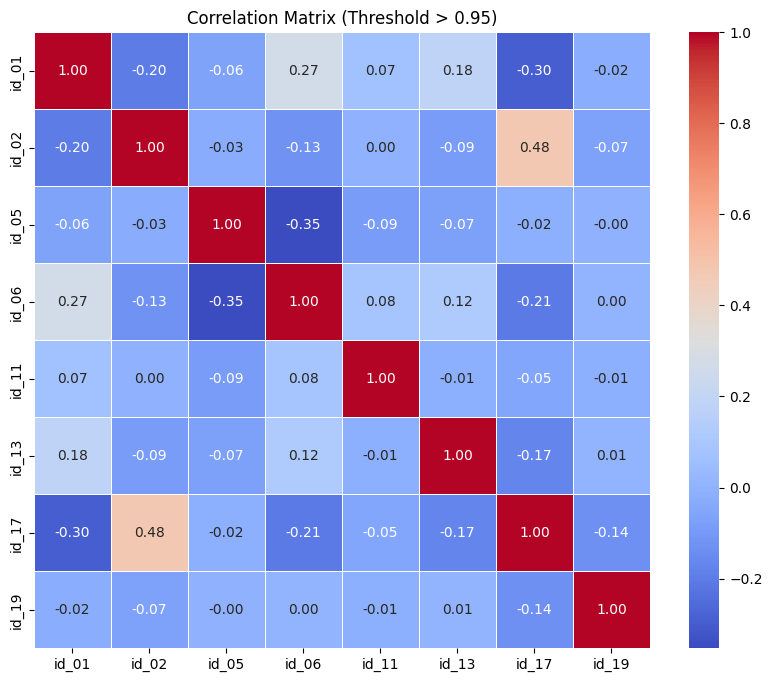

No high correlation pairs found in ID Features

Checking correlations for C Features...

High correlation pairs (correlation > 0.95):
C2 & C1: 1.00
C4 & C1: 0.97
C4 & C2: 0.97
C6 & C1: 0.98
C6 & C2: 0.97
C6 & C4: 0.96
C8 & C1: 0.97
C8 & C2: 0.98
C8 & C4: 0.96
C8 & C7: 0.98
C10 & C1: 0.96
C10 & C2: 0.97
C10 & C4: 0.95
C10 & C7: 0.99
C10 & C8: 1.00
C11 & C1: 1.00
C11 & C2: 0.99
C11 & C4: 0.97
C11 & C6: 0.99
C11 & C8: 0.96
C11 & C10: 0.96
C12 & C7: 1.00
C12 & C8: 0.98
C12 & C10: 0.98
C14 & C1: 0.95
C14 & C6: 0.98
C14 & C11: 0.96


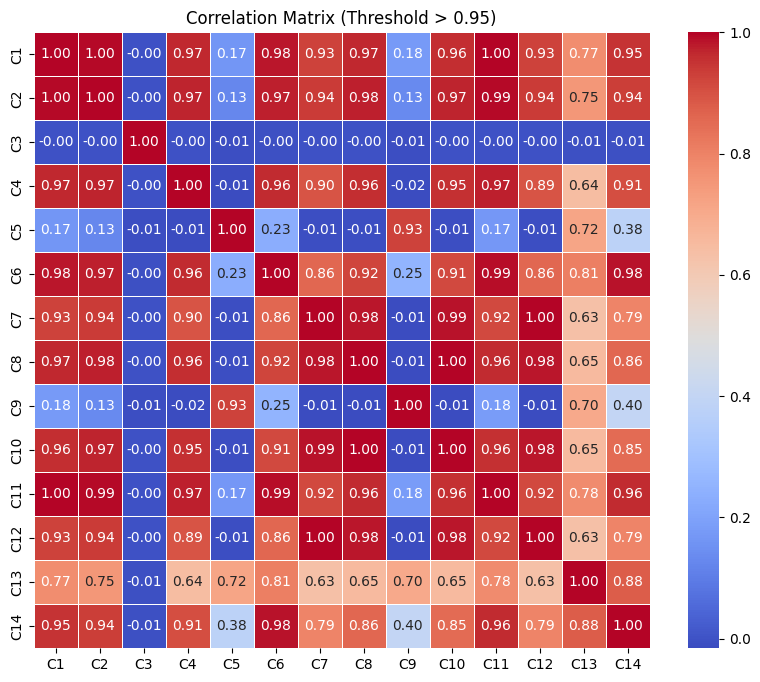

Found high correlation pairs in C Features:
[('C2', 'C1', 0.9950894592234939), ('C4', 'C1', 0.9678002004097163), ('C4', 'C2', 0.9721337740566047), ('C6', 'C1', 0.9822377722079176), ('C6', 'C2', 0.9748448481316238), ('C6', 'C4', 0.9623192744263843), ('C8', 'C1', 0.9677463528943373), ('C8', 'C2', 0.9758629919515445), ('C8', 'C4', 0.9599954810304452), ('C8', 'C7', 0.9829833764483118), ('C10', 'C1', 0.9582021807774743), ('C10', 'C2', 0.9706239088171714), ('C10', 'C4', 0.9524664323346516), ('C10', 'C7', 0.9850616676560336), ('C10', 'C8', 0.9969699489971502), ('C11', 'C1', 0.9965147332633475), ('C11', 'C2', 0.9938978018238349), ('C11', 'C4', 0.9745466372849689), ('C11', 'C6', 0.9911048342777391), ('C11', 'C8', 0.9627215780026751), ('C11', 'C10', 0.9560557324215362), ('C12', 'C7', 0.9994888253017926), ('C12', 'C8', 0.9830271643527599), ('C12', 'C10', 0.9838169468512061), ('C14', 'C1', 0.9517609999340592), ('C14', 'C6', 0.984201070361345), ('C14', 'C11', 0.9624645830405704)]

Step 5.2: Running

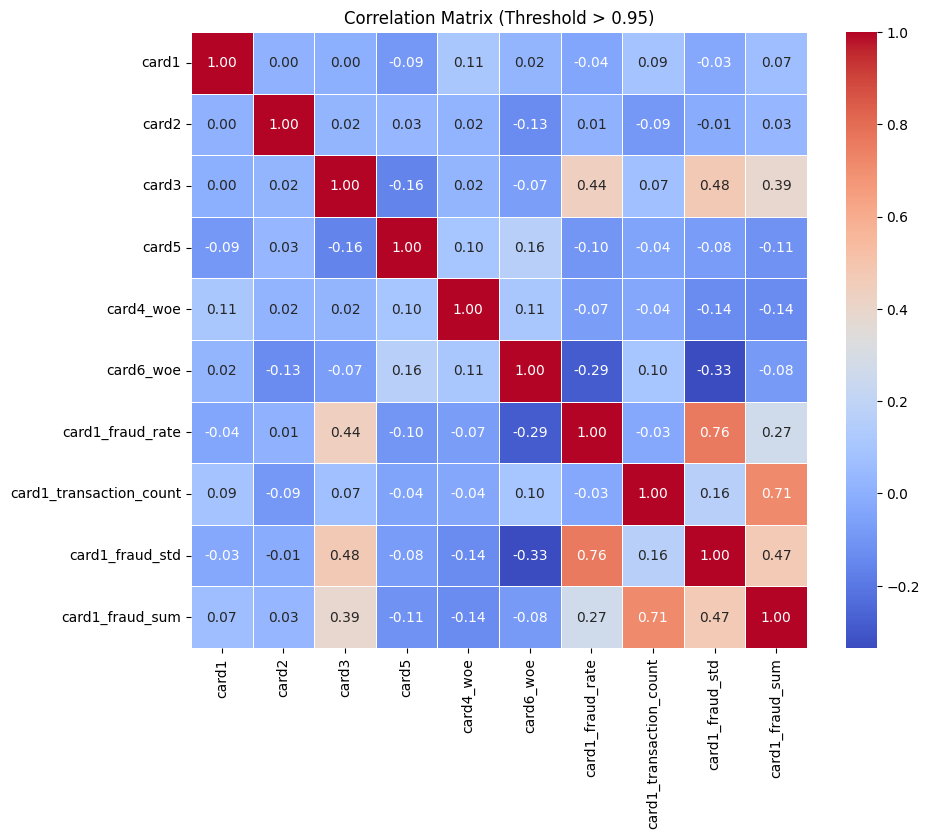

No high correlation pairs found in Card-related Features

Checking correlations for Address-related Features...

No pairs found with correlation greater than 0.95.


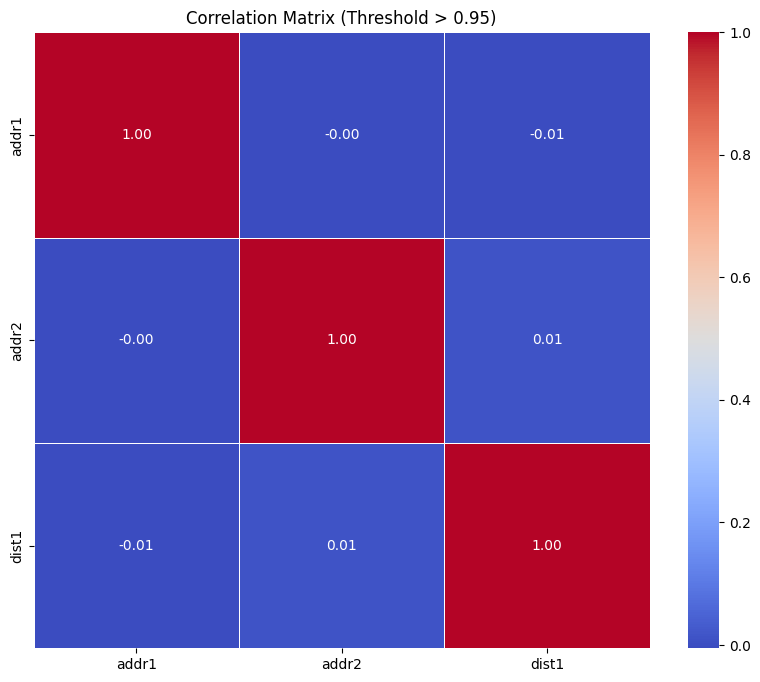

No high correlation pairs found in Address-related Features

Checking correlations for D Features...

No pairs found with correlation greater than 0.95.


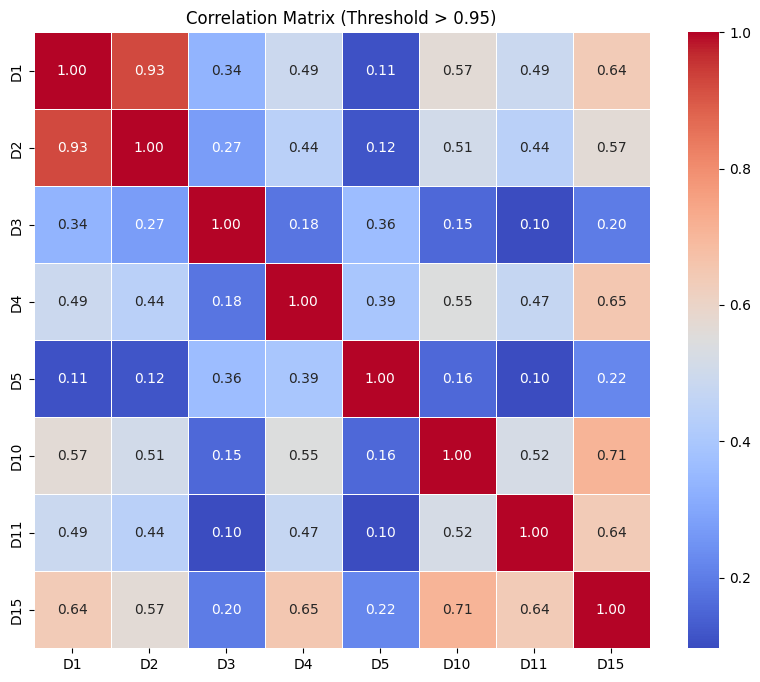

No high correlation pairs found in D Features

Checking correlations for ID Features...

No pairs found with correlation greater than 0.95.


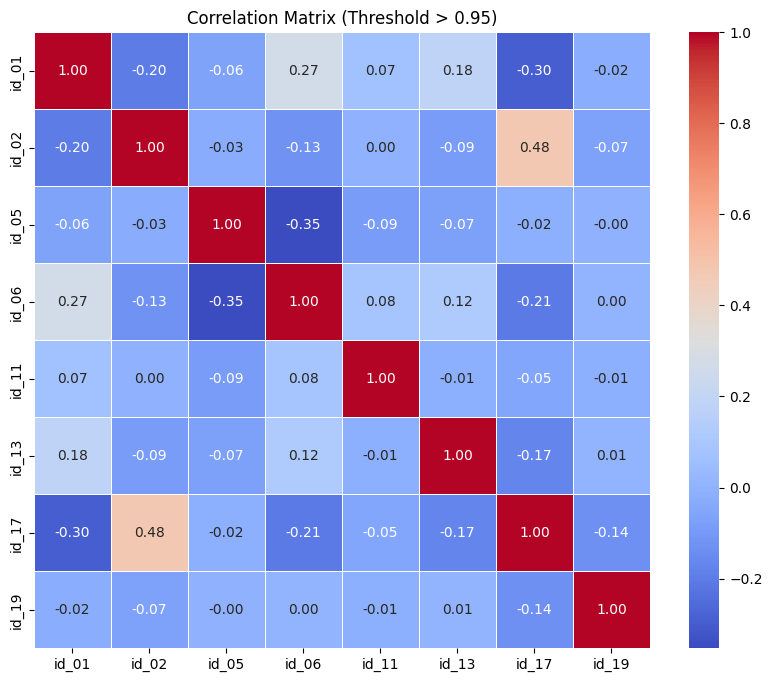

No high correlation pairs found in ID Features

Checking correlations for C Features...

High correlation pairs (correlation > 0.95):
C2 & C1: 1.00
C4 & C1: 0.97
C4 & C2: 0.97
C6 & C1: 0.98
C6 & C2: 0.97
C6 & C4: 0.96
C8 & C1: 0.97
C8 & C2: 0.98
C8 & C4: 0.96
C8 & C7: 0.98
C10 & C1: 0.96
C10 & C2: 0.97
C10 & C4: 0.95
C10 & C7: 0.99
C10 & C8: 1.00
C11 & C1: 1.00
C11 & C2: 0.99
C11 & C4: 0.97
C11 & C6: 0.99
C11 & C8: 0.96
C11 & C10: 0.96
C12 & C7: 1.00
C12 & C8: 0.98
C12 & C10: 0.98
C14 & C1: 0.95
C14 & C6: 0.98
C14 & C11: 0.96


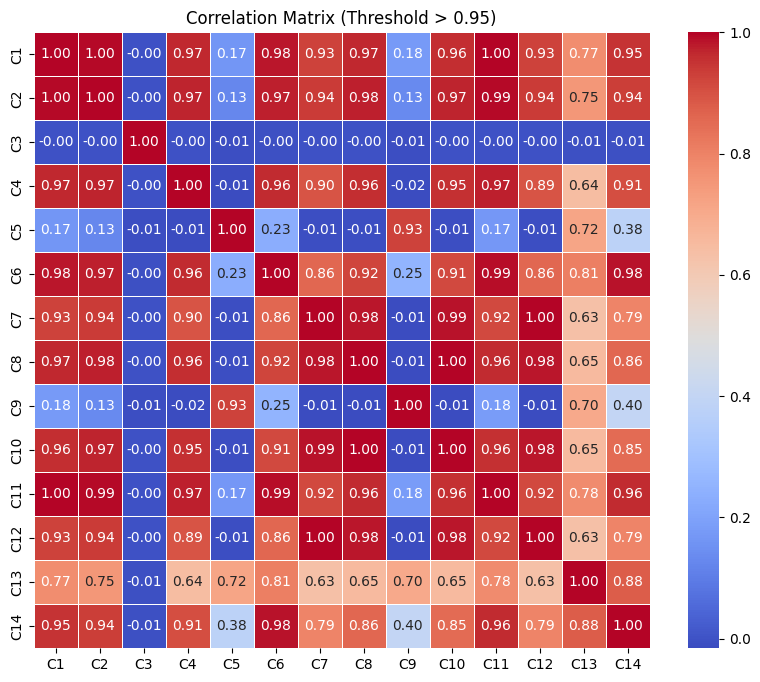

Found high correlation pairs in C Features:
[('C2', 'C1', 0.9950894592234939), ('C4', 'C1', 0.9678002004097163), ('C4', 'C2', 0.9721337740566047), ('C6', 'C1', 0.9822377722079176), ('C6', 'C2', 0.9748448481316238), ('C6', 'C4', 0.9623192744263843), ('C8', 'C1', 0.9677463528943373), ('C8', 'C2', 0.9758629919515445), ('C8', 'C4', 0.9599954810304452), ('C8', 'C7', 0.9829833764483118), ('C10', 'C1', 0.9582021807774743), ('C10', 'C2', 0.9706239088171714), ('C10', 'C4', 0.9524664323346516), ('C10', 'C7', 0.9850616676560336), ('C10', 'C8', 0.9969699489971502), ('C11', 'C1', 0.9965147332633475), ('C11', 'C2', 0.9938978018238349), ('C11', 'C4', 0.9745466372849689), ('C11', 'C6', 0.9911048342777391), ('C11', 'C8', 0.9627215780026751), ('C11', 'C10', 0.9560557324215362), ('C12', 'C7', 0.9994888253017926), ('C12', 'C8', 0.9830271643527599), ('C12', 'C10', 0.9838169468512061), ('C14', 'C1', 0.9517609999340592), ('C14', 'C6', 0.984201070361345), ('C14', 'C11', 0.9624645830405704)]

Checking batch 1/

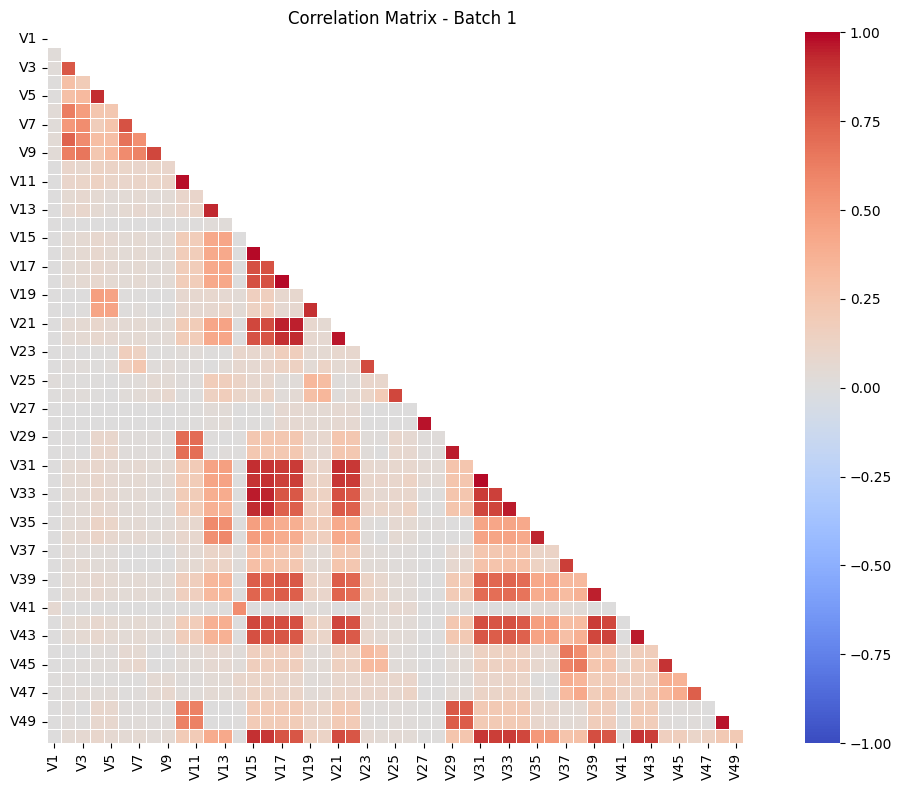

Keeping: V11
Dropping: ['V10']
Keeping: V15
Dropping: ['V33', 'V16', 'V34']
Keeping: V17
Dropping: ['V21', 'V18', 'V22']
Keeping: V28
Dropping: ['V27']
Keeping: V30
Dropping: ['V29']
Keeping: V32
Dropping: ['V31']
Keeping: V43
Dropping: ['V42']
Keeping: V49
Dropping: ['V48']

Processing batch 2/6: 50 columns
Found 10 high correlation pairs


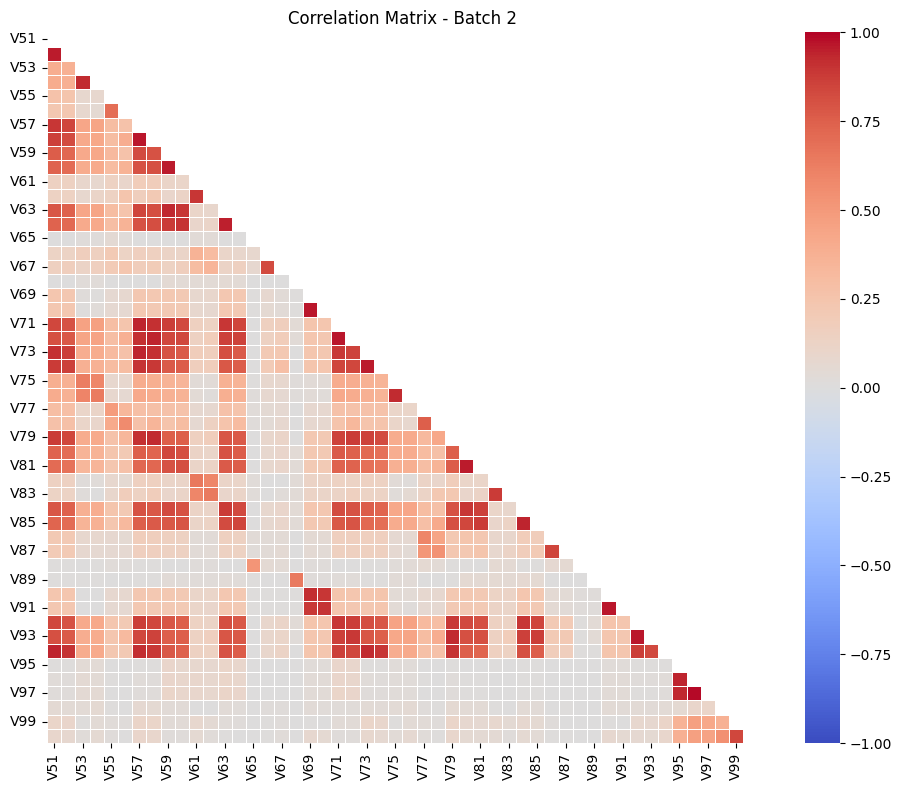

Keeping: V11
Dropping: ['V10']
Keeping: V16
Dropping: ['V15', 'V33', 'V34']
Keeping: V18
Dropping: ['V17', 'V21', 'V22']
Keeping: V28
Dropping: ['V27']
Keeping: V30
Dropping: ['V29']
Keeping: V32
Dropping: ['V31']
Keeping: V43
Dropping: ['V42']
Keeping: V49
Dropping: ['V48']
Keeping: V52
Dropping: ['V51']
Keeping: V58
Dropping: ['V57']
Keeping: V60
Dropping: ['V59']
Keeping: V70
Dropping: ['V69']
Keeping: V72
Dropping: ['V71']
Keeping: V74
Dropping: ['V73']
Keeping: V81
Dropping: ['V80']
Keeping: V91
Dropping: ['V90']
Keeping: V93
Dropping: ['V92']
Keeping: V97
Dropping: ['V96']

Processing batch 3/6: 50 columns
Found 49 high correlation pairs


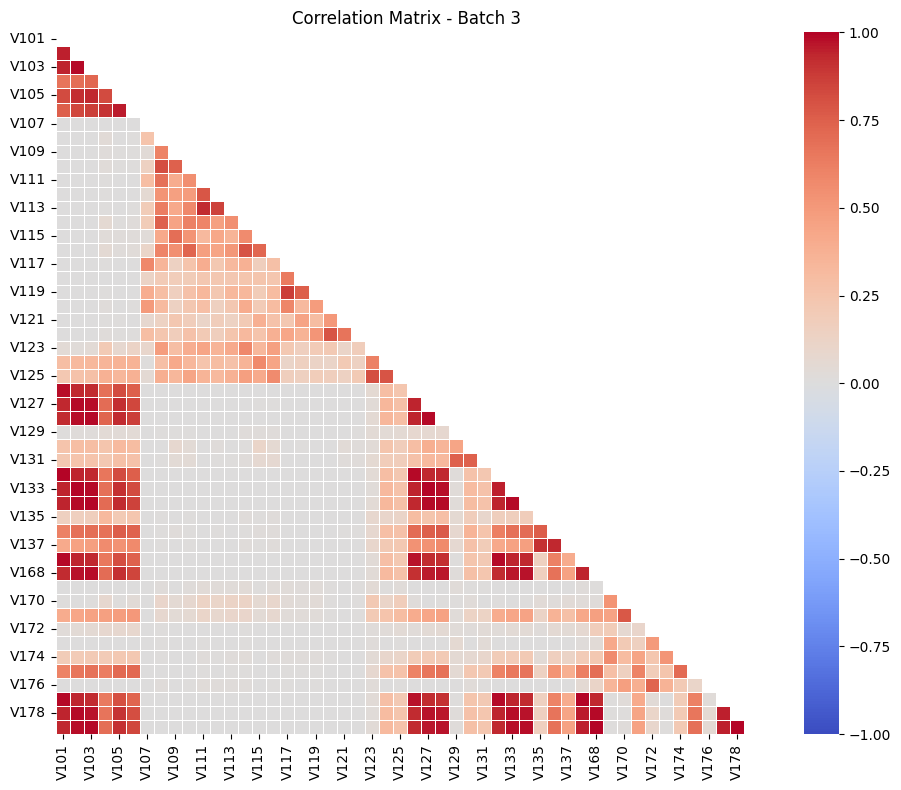

Keeping: V11
Dropping: ['V10']
Keeping: V16
Dropping: ['V15', 'V33', 'V34']
Keeping: V18
Dropping: ['V17', 'V21', 'V22']
Keeping: V28
Dropping: ['V27']
Keeping: V30
Dropping: ['V29']
Keeping: V32
Dropping: ['V31']
Keeping: V43
Dropping: ['V42']
Keeping: V49
Dropping: ['V48']
Keeping: V52
Dropping: ['V51']
Keeping: V58
Dropping: ['V57']
Keeping: V60
Dropping: ['V59']
Keeping: V70
Dropping: ['V69']
Keeping: V72
Dropping: ['V71']
Keeping: V74
Dropping: ['V73']
Keeping: V81
Dropping: ['V80']
Keeping: V91
Dropping: ['V90']
Keeping: V93
Dropping: ['V92']
Keeping: V97
Dropping: ['V96']
Keeping: V134
Dropping: ['V102', 'V103', 'V133', 'V179', 'V178', 'V127', 'V128', 'V168']
Keeping: V106
Dropping: ['V105']
Keeping: V132
Dropping: ['V101', 'V177', 'V167', 'V126']

Processing batch 4/6: 50 columns
Found 15 high correlation pairs


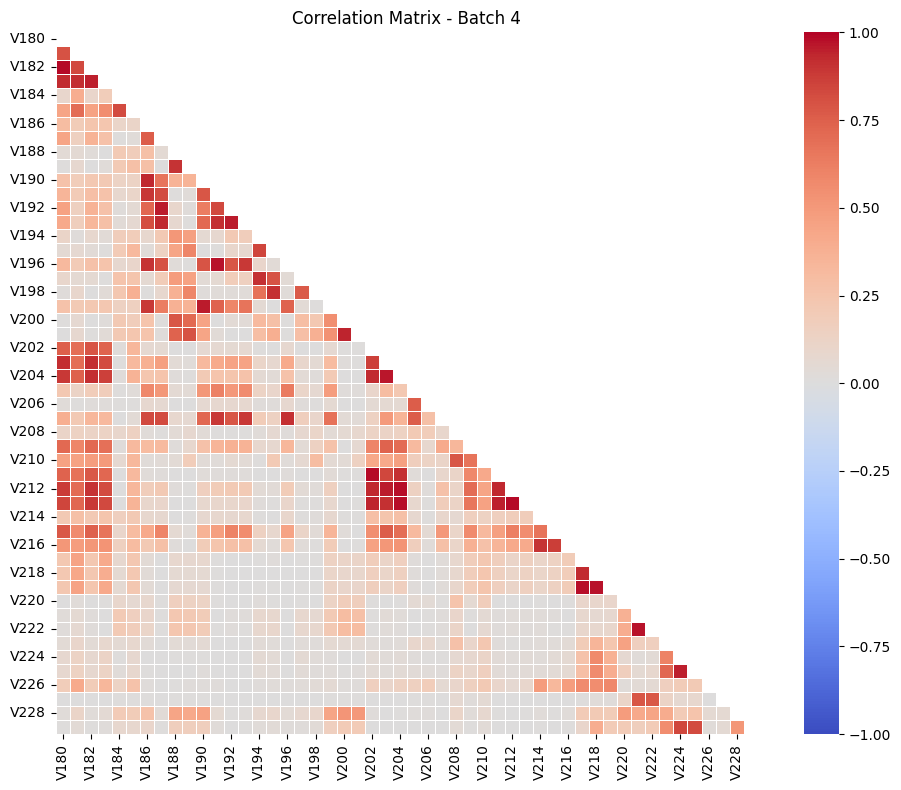

Keeping: V11
Dropping: ['V10']
Keeping: V16
Dropping: ['V15', 'V33', 'V34']
Keeping: V18
Dropping: ['V17', 'V21', 'V22']
Keeping: V28
Dropping: ['V27']
Keeping: V30
Dropping: ['V29']
Keeping: V32
Dropping: ['V31']
Keeping: V43
Dropping: ['V42']
Keeping: V49
Dropping: ['V48']
Keeping: V52
Dropping: ['V51']
Keeping: V58
Dropping: ['V57']
Keeping: V60
Dropping: ['V59']
Keeping: V70
Dropping: ['V69']
Keeping: V72
Dropping: ['V71']
Keeping: V74
Dropping: ['V73']
Keeping: V81
Dropping: ['V80']
Keeping: V91
Dropping: ['V90']
Keeping: V93
Dropping: ['V92']
Keeping: V97
Dropping: ['V96']
Keeping: V103
Dropping: ['V102', 'V127', 'V128', 'V133', 'V134', 'V168', 'V178', 'V179']
Keeping: V106
Dropping: ['V105']
Keeping: V126
Dropping: ['V101', 'V132', 'V167', 'V177']
Keeping: V182
Dropping: ['V180']
Keeping: V192
Dropping: ['V187', 'V193']
Keeping: V196
Dropping: ['V191']
Keeping: V199
Dropping: ['V190']
Keeping: V212
Dropping: ['V204', 'V213', 'V203']
Keeping: V211
Dropping: ['V202']
Keeping: V219

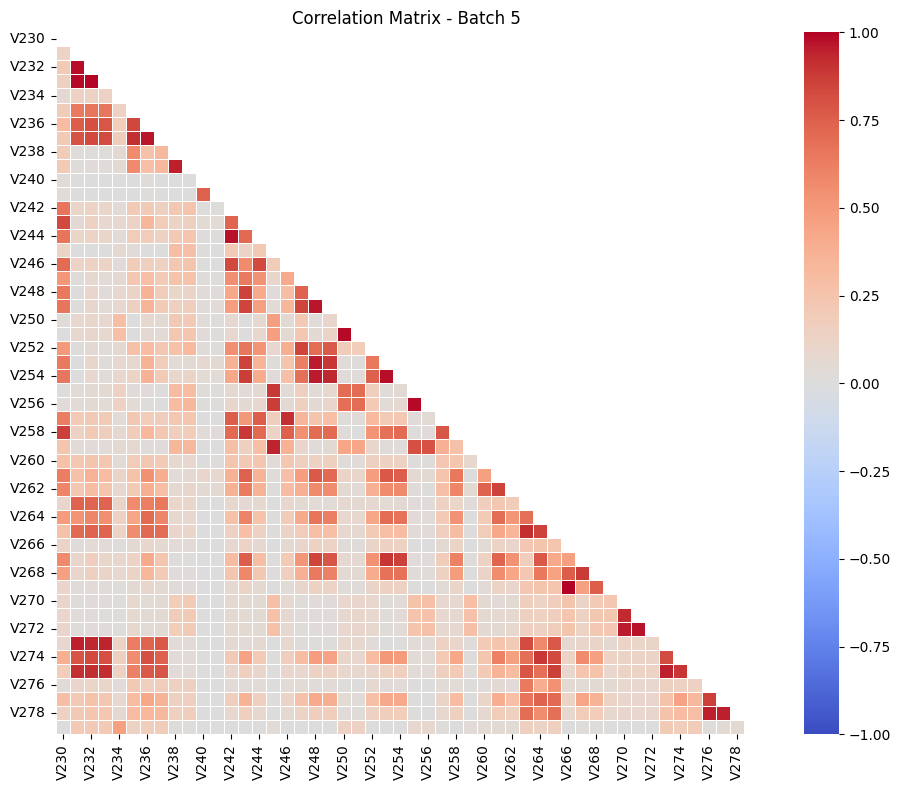

Keeping: V11
Dropping: ['V10']
Keeping: V16
Dropping: ['V15', 'V33', 'V34']
Keeping: V18
Dropping: ['V17', 'V21', 'V22']
Keeping: V28
Dropping: ['V27']
Keeping: V30
Dropping: ['V29']
Keeping: V32
Dropping: ['V31']
Keeping: V43
Dropping: ['V42']
Keeping: V49
Dropping: ['V48']
Keeping: V52
Dropping: ['V51']
Keeping: V58
Dropping: ['V57']
Keeping: V60
Dropping: ['V59']
Keeping: V70
Dropping: ['V69']
Keeping: V72
Dropping: ['V71']
Keeping: V74
Dropping: ['V73']
Keeping: V81
Dropping: ['V80']
Keeping: V91
Dropping: ['V90']
Keeping: V93
Dropping: ['V92']
Keeping: V97
Dropping: ['V96']
Keeping: V103
Dropping: ['V102', 'V127', 'V128', 'V133', 'V134', 'V168', 'V178', 'V179']
Keeping: V106
Dropping: ['V105']
Keeping: V126
Dropping: ['V101', 'V132', 'V167', 'V177']
Keeping: V182
Dropping: ['V180']
Keeping: V192
Dropping: ['V187', 'V193']
Keeping: V196
Dropping: ['V191']
Keeping: V199
Dropping: ['V190']
Keeping: V204
Dropping: ['V203', 'V212', 'V213']
Keeping: V211
Dropping: ['V202']
Keeping: V219

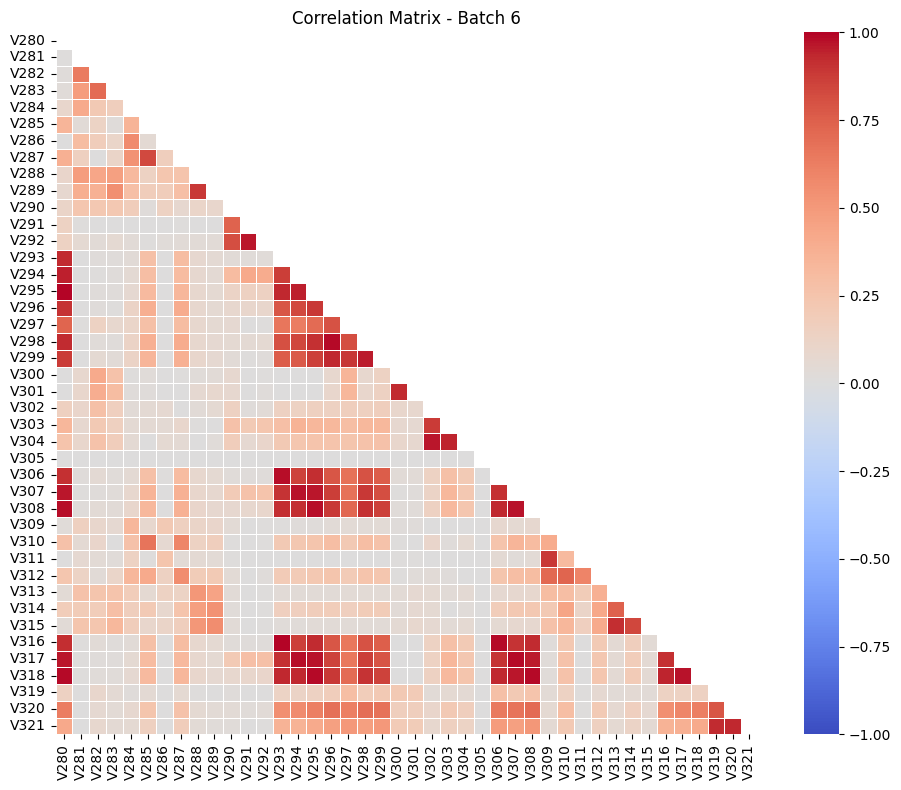

Keeping: V11
Dropping: ['V10']
Keeping: V16
Dropping: ['V15', 'V33', 'V34']
Keeping: V18
Dropping: ['V17', 'V21', 'V22']
Keeping: V28
Dropping: ['V27']
Keeping: V30
Dropping: ['V29']
Keeping: V32
Dropping: ['V31']
Keeping: V43
Dropping: ['V42']
Keeping: V49
Dropping: ['V48']
Keeping: V52
Dropping: ['V51']
Keeping: V58
Dropping: ['V57']
Keeping: V60
Dropping: ['V59']
Keeping: V70
Dropping: ['V69']
Keeping: V72
Dropping: ['V71']
Keeping: V74
Dropping: ['V73']
Keeping: V81
Dropping: ['V80']
Keeping: V91
Dropping: ['V90']
Keeping: V93
Dropping: ['V92']
Keeping: V97
Dropping: ['V96']
Keeping: V103
Dropping: ['V102', 'V127', 'V128', 'V133', 'V134', 'V168', 'V178', 'V179']
Keeping: V106
Dropping: ['V105']
Keeping: V126
Dropping: ['V101', 'V132', 'V167', 'V177']
Keeping: V182
Dropping: ['V180']
Keeping: V192
Dropping: ['V187', 'V193']
Keeping: V196
Dropping: ['V191']
Keeping: V199
Dropping: ['V190']
Keeping: V204
Dropping: ['V203', 'V212', 'V213']
Keeping: V211
Dropping: ['V202']
Keeping: V219

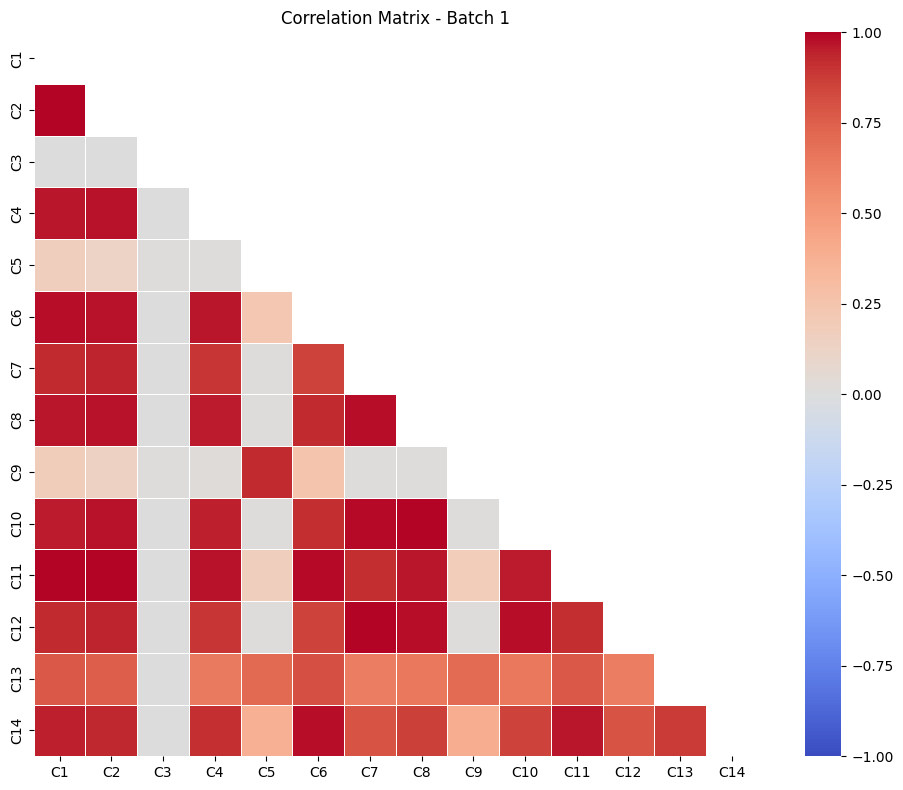

Keeping: C11
Dropping: ['C8', 'C1', 'C10', 'C2', 'C4', 'C6', 'C7', 'C12', 'C14']

Dropping 9 columns in total
Final train shape: (590540, 275)
Final test shape: (506691, 303)
Dropped columns: ['C8', 'C1', 'C10', 'C2', 'C4', 'C6', 'C7', 'C12', 'C14']
Correlation groups (with drops): [['C2', 'C1', 'C4', 'C6', 'C8', 'C7', 'C10', 'C11', 'C12', 'C14']]
Correlation groups (without drops): []
Outliers capped successfully
Outliers capped successfully
Preparing data for modeling...
Train data shape: (590540, 275)
Test data shape: (506691, 303)
Number of test IDs extracted: 506691
Number of common columns between train and test: 264
9 columns in train are not in test
38 columns in test are not in train
Final shapes - X: (590540, 264), y: (590540,), X_test: (506691, 264)
Training features shape: (590540, 264)
Testing features shape: (506691, 264)

Step 11: Selecting important features...

Selecting top 100 features using Random Forest importance...
Detected infinite values. Replacing with NaN...


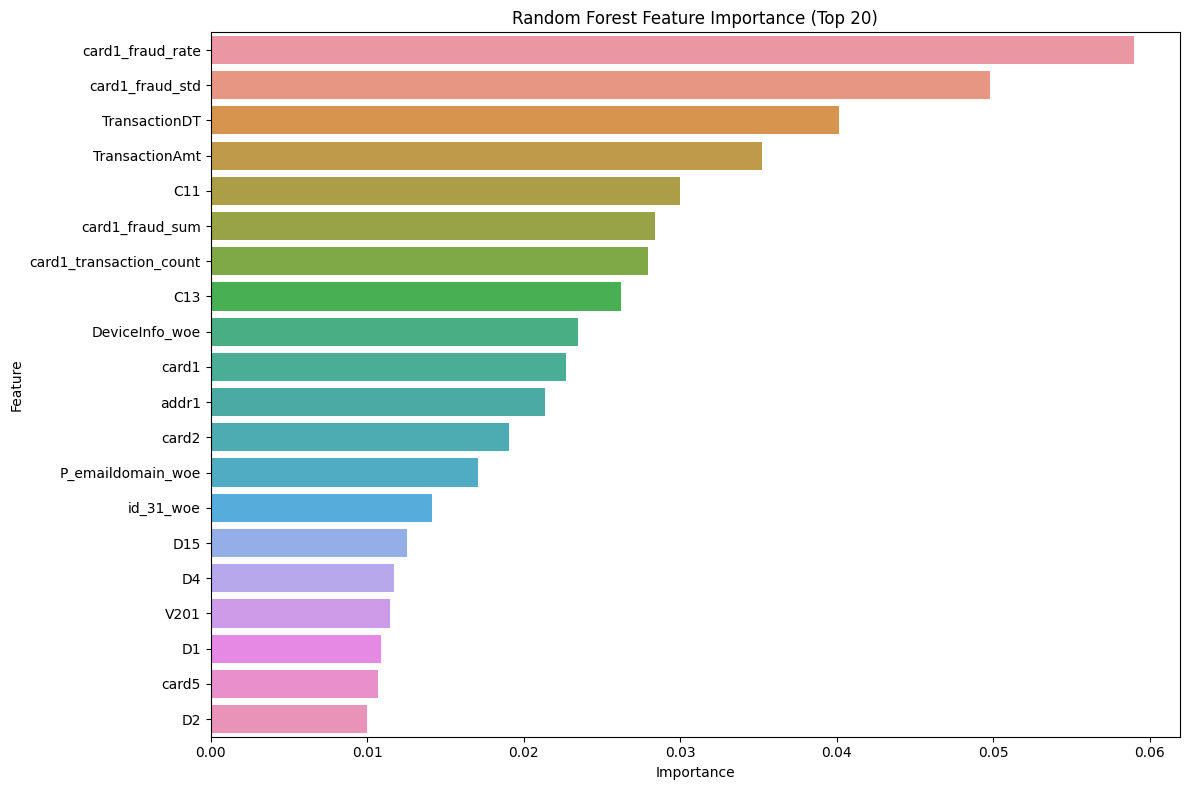

🏃 View run feature_selection at: https://dagshub.com/mkoko22/mkoko22-ML-2.mlflow/#/experiments/0/runs/7cdb1ee75b9741b09aa48eff676aca96
🧪 View experiment at: https://dagshub.com/mkoko22/mkoko22-ML-2.mlflow/#/experiments/0

Step 12: Training model with cross-validation...

Training XGBoost model with cross-validation...

Fold 1/5
Balancing the dataset using Random Under Sampling...
Original class distribution: isFraud
0.0    455901
1.0     16531
Name: count, dtype: int64
Resampled class distribution: isFraud
0.0    82655
1.0    16531
Name: count, dtype: int64
[0]	validation_0-auc:0.88907
[100]	validation_0-auc:0.94929
[200]	validation_0-auc:0.95844
[299]	validation_0-auc:0.96329
Fold 1 - Best threshold: 0.6800, Best F1: 0.6991
Fold 1 AUC: 0.9633, Accuracy: 0.9809, Precision: 0.7779, Recall: 0.6348, F1: 0.6991

Fold 2/5
Balancing the dataset using Random Under Sampling...
Original class distribution: isFraud
0.0    455901
1.0     16531
Name: count, dtype: int64
Resampled class distributio

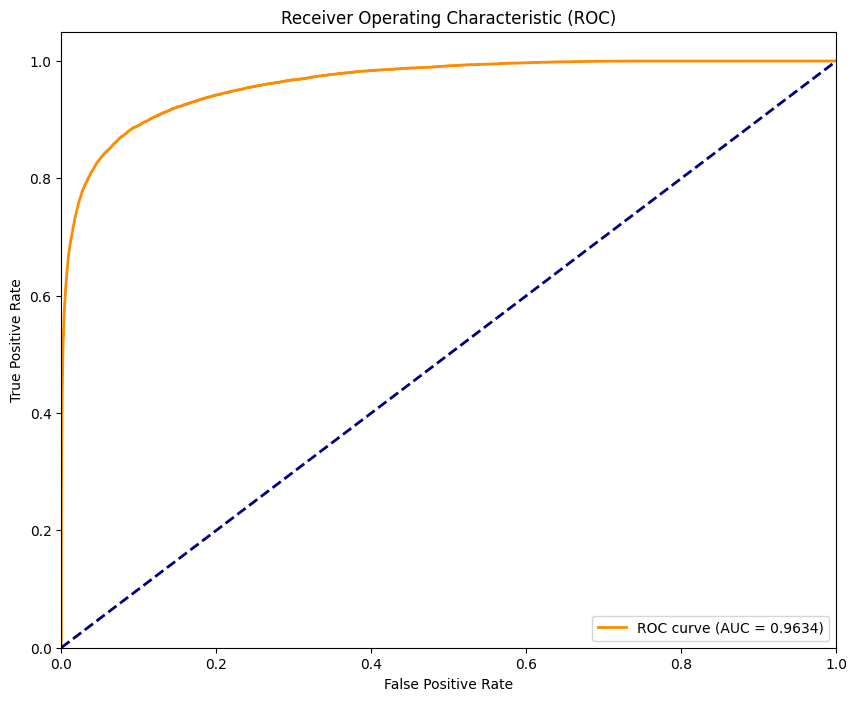


Optimal threshold determined from cross-validation: 0.6560

Overall AUC score: 0.9634
Overall Accuracy score: 0.9802
Overall Precision score: 0.7539
Overall Recall score: 0.6442
Overall F1 score: 0.6947

Cross-validation AUC scores: [0.9633, 0.9641, 0.962, 0.9643, 0.9631]
Mean CV AUC score: 0.9634
Mean Accuracy score: 0.9803
Mean Precision score: 0.7574
Mean Recall score: 0.6460
Mean F1 score: 0.6966


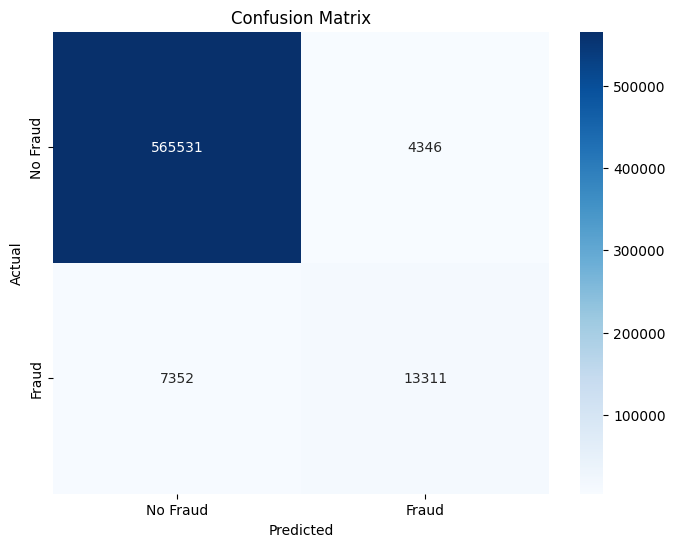

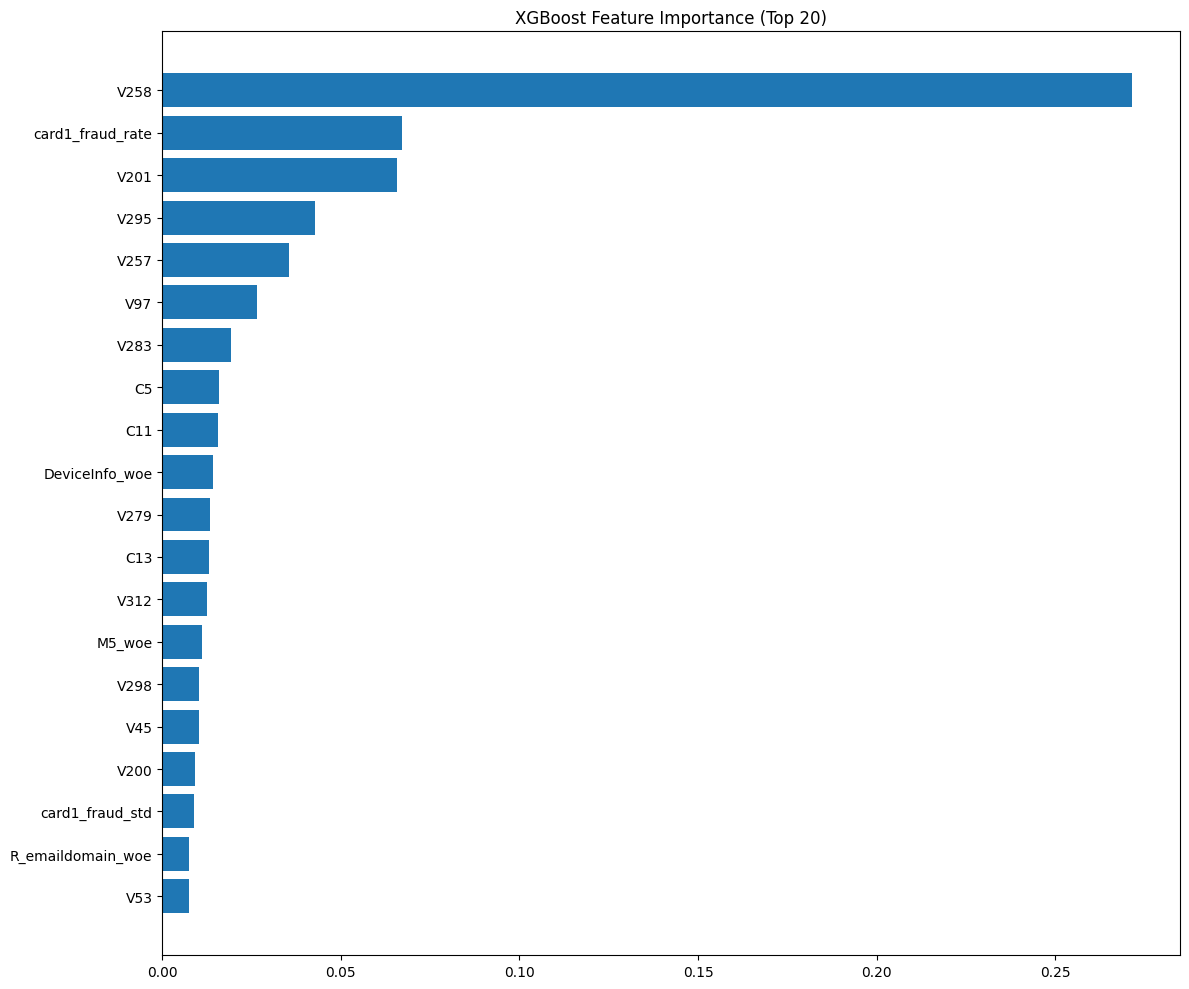


Step 13: Logging the model with MLflow...


2025/04/29 00:29:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run model_training at: https://dagshub.com/mkoko22/mkoko22-ML-2.mlflow/#/experiments/0/runs/807fe37cb3a4463d863d9cde681bbff8
🧪 View experiment at: https://dagshub.com/mkoko22/mkoko22-ML-2.mlflow/#/experiments/0

Step 14: Making predictions on test data...

Step 15: Creating submission file...
Submission saved to /kaggle/working/submission.csv

MLflow Run ID: 65e2b21637874cb1b95c7cce8b93a415

Fraud detection pipeline completed successfully!


In [47]:
def train_xgboost_with_cv(X, y, selected_features, n_folds=5):
    print("\nTraining XGBoost model with cross-validation...")
    
    X_selected = X[selected_features]
    
    model = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=1,
        objective='binary:logistic',
        tree_method='hist',
        random_state=42,
        use_label_encoder=False,
        eval_metric='auc'
    )
    
    kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    cv_scores = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    fold_predictions = []
   
    optimal_threshold = 0.6
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_selected, y)):
        print(f"\nFold {fold+1}/{n_folds}")
        
        X_train_fold, X_val_fold = X_selected.iloc[train_idx], X_selected.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        
       
        X_train_balanced, y_train_balanced = balance_data(X_train_fold, y_train_fold)
       
        model.fit(
            X_train_balanced, 
            y_train_balanced, 
            eval_set=[(X_val_fold, y_val_fold)],
            verbose=100,
            early_stopping_rounds=50
        )
        
        val_preds = model.predict_proba(X_val_fold)[:, 1]
        
        thresholds = np.arange(0.3, 0.8, 0.02) 
        best_f1 = 0
        best_threshold = 0.5
        
        for threshold in thresholds:
            y_pred_temp = (val_preds >= threshold).astype(int)
            f1 = f1_score(y_val_fold, y_pred_temp)
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        print(f"Fold {fold+1} - Best threshold: {best_threshold:.4f}, Best F1: {best_f1:.4f}")
        
        y_pred = (val_preds >= best_threshold).astype(int)
       
        auc_score = roc_auc_score(y_val_fold, val_preds)
        accuracy = accuracy_score(y_val_fold, y_pred)
        precision = precision_score(y_val_fold, y_pred)
        recall = recall_score(y_val_fold, y_pred)
        f1 = f1_score(y_val_fold, y_pred)
       
        optimal_threshold = ((optimal_threshold * fold) + best_threshold) / (fold + 1)
       
        cv_scores.append(auc_score)
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        
        print(f"Fold {fold+1} AUC: {auc_score:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
        
        fold_predictions.append(pd.Series(val_preds, index=val_idx))
    
    oof_predictions = pd.concat(fold_predictions).sort_index()
    
    fpr, tpr, thresholds = roc_curve(y, oof_predictions)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig("/kaggle/working/roc_curve.png")
    plt.show()
    
    print(f"\nOptimal threshold determined from cross-validation: {optimal_threshold:.4f}")
   
    y_pred_binary = (oof_predictions >= optimal_threshold).astype(int)
    overall_auc = roc_auc_score(y, oof_predictions)
    overall_accuracy = accuracy_score(y, y_pred_binary)
    overall_precision = precision_score(y, y_pred_binary)
    overall_recall = recall_score(y, y_pred_binary)
    overall_f1 = f1_score(y, y_pred_binary)
    
    mean_auc = np.mean(cv_scores)
    mean_accuracy = np.mean(accuracy_scores)
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_f1 = np.mean(f1_scores)
    
    print(f"\nOverall AUC score: {overall_auc:.4f}")
    print(f"Overall Accuracy score: {overall_accuracy:.4f}")
    print(f"Overall Precision score: {overall_precision:.4f}")
    print(f"Overall Recall score: {overall_recall:.4f}")
    print(f"Overall F1 score: {overall_f1:.4f}")
    print(f"\nCross-validation AUC scores: {[round(score, 4) for score in cv_scores]}")
    print(f"Mean CV AUC score: {mean_auc:.4f}")
    print(f"Mean Accuracy score: {mean_accuracy:.4f}")
    print(f"Mean Precision score: {mean_precision:.4f}")
    print(f"Mean Recall score: {mean_recall:.4f}")
    print(f"Mean F1 score: {mean_f1:.4f}")
    
    cm = confusion_matrix(y, y_pred_binary)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    plt.figure(figsize=(12, 10))
    sorted_idx = np.argsort(model.feature_importances_)[-20:]  # Top 20 features
    plt.barh(range(len(sorted_idx)), model.feature_importances_[sorted_idx])
    plt.yticks(range(len(sorted_idx)), X_selected.columns[sorted_idx])
    plt.title('XGBoost Feature Importance (Top 20)')
    plt.tight_layout()
    plt.savefig("/kaggle/working/feature_importance.png")
    plt.show()
    mlflow.log_artifact("/kaggle/working/roc_curve.png")
    
    return model, overall_auc, oof_predictions, optimal_threshold, cv_scores, accuracy_scores, precision_scores, recall_scores, f1_scores


def main():
    setup_mlflow()
   
    print("Step 1: Loading data...")
    train, test, ids = load_data()
    
    # Store original test IDs before any preprocessing
    original_test_ids = ids.copy()
    
    print("\nStep 2: Optimizing memory usage...")
    train = reduce_mem_usage(train)
    test = reduce_mem_usage(test)
    
    print("\nStep 3: Analyzing target distribution...")
    display_target_distribution(train)
   
    print("\nStep 4: Inspecting data...")
    train, test = inspect_data(train, test)
    
    print("\nStep 5: Cleaning data...")
    train, test = clean_data(train, test, 'isFraud', missing_threshold=0.8)

    analyze_v_columns(train, step=20)

    available_columns = train.columns.tolist()
    chunks = {
        'Card-related Features': [col for col in ['card1', 'card2', 'card3', 'card5'] if col in available_columns],
        'Address-related Features': [col for col in ['addr1', 'addr2', 'dist1'] if col in available_columns],
        'D Features': [col for col in ['D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15'] if col in available_columns],
        'ID Features': [col for col in ['id_01', 'id_02', 'id_05', 'id_06', 'id_11', 'id_13', 'id_17', 'id_19'] if col in available_columns],
        'C Features': [col for col in ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14'] if col in available_columns]
    }
    
    for chunk_name, chunk_columns in list(chunks.items()):
        if len(chunk_columns) < 2:
            print(f"Skipping {chunk_name} - not enough columns available")
            del chunks[chunk_name]
    
    if chunks:
        run_correlation_check_for_chunks(train, chunks, threshold=0.95)
    
    print("\nStep 5.2: Running batch correlation check for V features...")
    if any(col.startswith('V') for col in available_columns):
        v_correlations = batch_correlation_check(train, feature_prefix='V', threshold=0.9, batch_size=50)
    else:
        print("No V features found in the dataframe at this point")
    
    train, test = create_aggregate_features(train, test)
   
    print("\nStep 7: Encoding categorical variables...")
    train, test = woe_encoding(train, test, 'isFraud')
    train, test = missing_values(train, test)
    
    chunks = {
            'Card-related Features': [
                'card1', 'card2', 'card3', 'card5', 'card4_woe', 'card6_woe', 
                'card1_fraud_rate', 'card1_transaction_count', 'card1_fraud_std', 'card1_fraud_sum'
            ],
            'Address-related Features': [
                'addr1', 'addr2', 'dist1'
            ],
            'D Features': [
                'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15'
            ],
            'ID Features': [
                'id_01', 'id_02', 'id_05', 'id_06', 'id_11', 'id_13', 'id_17', 'id_19'
            ],
            'C Features': [
                'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14'
            ]
        }
    
    print("\nAnalyzing correlations in feature chunks...")
    run_correlation_check_for_chunks(train, chunks, threshold=0.95)
    
    high_corr_pairs = batch_correlation_check(train, feature_prefix='V', threshold=0.9, batch_size=50)
   
    train, test, dropped_columns, correlation_groups = analyze_and_drop_correlated_features(
        train=train,
        test=test,
        prefixes=['V'],
        threshold=0.95,
        batch_size=50,
        plot=True,
        verbose=True
    )

    train, test, dropped_columns, correlation_groups = analyze_and_drop_correlated_features(
        train=train,
        test=test,
        prefixes=['C'],
        threshold=0.95,
        batch_size=50,
        plot=True,
        verbose=True
    )
    
    correlation_groups_only = get_feature_correlation_groups(
        df=train,
        prefixes=['V'],
        threshold=0.95,
        batch_size=50
    )

    print("Dropped columns:", dropped_columns)
    print("Correlation groups (with drops):", correlation_groups)
    print("Correlation groups (without drops):", correlation_groups_only)
    
    train = cap_outliers(train, percentile=98)
    test = cap_outliers(test, percentile=98)
    
    mlflow.log_param("features_after_engineering", train.shape[1])

    X, y, test_ids, X_test = prepare_data(train, test)
    
    print(f"Training features shape: {X.shape}")
    print(f"Testing features shape: {X_test.shape}")
    
    print("\nStep 11: Selecting important features...")
    with mlflow.start_run(run_name="feature_selection", nested=True):
        selected_features = feature_selection_with_importance(X, y, n_features_to_select=100)
        mlflow.log_param("selected_feature_count", len(selected_features))
   
    print("\nStep 12: Training model with cross-validation...")
    with mlflow.start_run(run_name="model_training", nested=True):
        model, overall_auc, oof_predictions, optimal_threshold, cv_scores, accuracy_scores, precision_scores, recall_scores, f1_scores = train_xgboost_with_cv(
            X, y, selected_features, n_folds=5
        )
       
        mlflow.log_metric("overall_auc", overall_auc)
        mlflow.log_metric("mean_cv_auc", np.mean(cv_scores))
        mlflow.log_metric("mean_accuracy", np.mean(accuracy_scores))
        mlflow.log_metric("mean_precision", np.mean(precision_scores))
        mlflow.log_metric("mean_recall", np.mean(recall_scores))
        mlflow.log_metric("mean_f1", np.mean(f1_scores))
        
        print("\nStep 13: Logging the model with MLflow...")
        mlflow.sklearn.log_model(model, "fraud_detection_model")
        
        mlflow.log_params({
            "model_type": "XGBoost",
            "n_estimators": model.n_estimators,
            "max_depth": model.max_depth,
            "learning_rate": model.learning_rate,
            "optimal_threshold": optimal_threshold
        })
    
    print("\nStep 14: Making predictions on test data...")
    test_predictions_proba = model.predict_proba(X_test[selected_features])[:, 1]
    test_predictions = (test_predictions_proba >= optimal_threshold).astype(int)
    
    print("\nStep 15: Creating submission file...")
    submission = pd.DataFrame({
        'TransactionID': original_test_ids,
        'isFraud': test_predictions_proba
    })
    
    submission_path = "/kaggle/working/submission.csv"
    submission.to_csv(submission_path, index=False)
    print(f"Submission saved to {submission_path}")
    
    mlflow.log_artifact(submission_path)
    run_id = mlflow.active_run().info.run_id
    print(f"\nMLflow Run ID: {run_id}")
    
    print("\nFraud detection pipeline completed successfully!")

if __name__ == "__main__":
    main()

In [101]:
mlflow.log_artifact("/kaggle/working/submission.csv", artifact_path="submissions")